In [1]:
# Install Taichi and required dependencies
!pip install taichi matplotlib numpy pillow
!pip install git+https://github.com/Worter623/TaiCrowd.git

import taichi as ti
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
import math

# Initialize Taichi (use CPU for Colab compatibility)
ti.init(arch=ti.cpu)  # Use ti.gpu if CUDA is available


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 MB 19.2 MB/s eta 0:00:00
  Cloning https://github.com/Worter623/TaiCrowd.git to /tmp/pip-req-build-1jzslj5r
  Running command git clone --filter=blob:none --quiet https://github.com/Worter623/TaiCrowd.git /tmp/pip-req-build-1jzslj5r
  Resolved https://github.com/Worter623/TaiCrowd.git to commit 8882426b6ffa174ec497ee3312e2752449e015cf
ERROR: git+https://github.com/Worter623/TaiCrowd.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
[Taichi] version 1.7.3, llvm 15.0.4, commit 5ec301be, linux, python 3.11.13
[Taichi] Starting on arch=x64


In [32]:
@ti.data_oriented
class BehavioralHeuristicsModel:
    def __init__(self, max_agents=1000, scenario_width=10.0, scenario_height=10.0):
        # Vadere BHM Parameters (same as before)
        self.step_length_intercept = 0.1
        self.step_length_slope_speed = 0.0345
        self.step_length_sd = 0.0036
        self.tangential_evasion = True
        self.sideways_evasion = True
        self.follower_proximity_navigation = True
        self.evasion_detour_threshold = 0.1
        self.follower_distance = 10.0
        self.distance_to_keep = 0.2
        self.follower_angle_movement = 1.5707963267948966
        self.follower_angle_position = 1.5707963267948966
        self.preffered_speed= 1

        # Agent properties
        self.max_agents = max_agents
        self.scenario_width = scenario_width
        self.scenario_height = scenario_height

        # Taichi fields
        self.positions = ti.Vector.field(2, dtype=ti.f32, shape=max_agents)
        self.velocities = ti.Vector.field(2, dtype=ti.f32, shape=max_agents)
        self.targets = ti.Vector.field(2, dtype=ti.f32, shape=max_agents)
        self.radii = ti.field(dtype=ti.f32, shape=max_agents)
        self.preferred_speeds = ti.field(dtype=ti.f32, shape=max_agents)
        self.active = ti.field(dtype=ti.i32, shape=max_agents)
        self.current_heuristic = ti.field(dtype=ti.i32, shape=max_agents)

        # Obstacles
        self.obstacles = ti.Vector.field(2, dtype=ti.f32, shape=100)
        self.obstacle_radii = ti.field(dtype=ti.f32, shape=100)
        self.num_obstacles = ti.field(dtype=ti.i32, shape=())

        # Heuristic types
        self.STEP_OR_WAIT = 0
        self.TANGENTIAL_EVASION = 1
        self.SIDEWAYS_EVASION = 2
        self.FOLLOWER = 3

    @ti.func
    def calculate_step_length(self, preferred_speed: ti.f32) -> ti.f32:
        """Calculate step length based on Vadere BHM parameters"""
        return self.step_length_intercept + self.step_length_slope_speed * preferred_speed

    @ti.func
    def distance(self, p1: ti.types.vector(2, ti.f32), p2: ti.types.vector(2, ti.f32)) -> ti.f32:
        """Calculate Euclidean distance between two points"""
        return (p1 - p2).norm()

    @ti.func
    def normalize_safe(self, v: ti.types.vector(2, ti.f32)) -> ti.types.vector(2, ti.f32):
        """Safely normalize a vector - FIXED to avoid return in if block"""
        norm = v.norm()
        result = ti.Vector([0.0, 0.0])

        # Use conditional assignment instead of return in if block
        if norm > 1e-6:
            result = v / norm
        # If norm <= 1e-6, result remains [0.0, 0.0]

        return result

    @ti.func
    def check_collision(self, pos: ti.types.vector(2, ti.f32), next_pos: ti.types.vector(2, ti.f32),
                       agent_id: ti.i32) -> ti.i32:
        """Check if moving from pos to next_pos would cause collision - FIXED"""
        collision = 0
        agent_radius = self.radii[agent_id]

        # Check collision with other agents
        for other_id in range(self.max_agents):
            # Only check if no collision found yet and valid other agent
            if collision == 0 and other_id != agent_id and self.active[other_id]:
                other_pos = self.positions[other_id]
                other_radius = self.radii[other_id]
                min_distance = agent_radius + other_radius + self.distance_to_keep

                if self.distance(next_pos, other_pos) < min_distance:
                    collision = 1

        # Check collision with obstacles only if no agent collision found
        for obs_id in range(self.num_obstacles[None]):
            if collision == 0:  # Only check if no collision found yet
                obs_pos = self.obstacles[obs_id]
                obs_radius = self.obstacle_radii[obs_id]
                min_distance = agent_radius + obs_radius

                if self.distance(next_pos, obs_pos) < min_distance:
                    collision = 1

        return collision

    @ti.func
    def step_or_wait_heuristic(self, agent_id: ti.i32) -> ti.types.vector(2, ti.f32):
        """Implement step or wait heuristic - FIXED"""
        pos = self.positions[agent_id]
        target = self.targets[agent_id]
        step_length = self.calculate_step_length(self.preferred_speeds[agent_id])

        # Direction towards target
        direction = self.normalize_safe(target - pos)
        next_pos = pos + direction * step_length
        result = pos  # Default to staying in place

        # Check for collision and assign result
        if self.check_collision(pos, next_pos, agent_id) == 0:
            result = next_pos

        return result

    @ti.func
    def tangential_evasion_heuristic(self, agent_id: ti.i32) -> ti.types.vector(2, ti.f32):
        """Implement tangential evasion heuristic - FIXED"""
        pos = self.positions[agent_id]
        target = self.targets[agent_id]
        step_length = self.calculate_step_length(self.preferred_speeds[agent_id])

        # First try direct step
        direction = self.normalize_safe(target - pos)
        next_pos = pos + direction * step_length
        result = pos  # Default to staying

        if self.check_collision(pos, next_pos, agent_id) == 0:
            result = next_pos
        else:
            # Find closest conflicting agent
            closest_agent = -1
            min_distance = 1000.0  # Use large value instead of float('inf')

            for other_id in range(self.max_agents):
                if other_id != agent_id and self.active[other_id]:
                    dist = self.distance(pos, self.positions[other_id])
                    if dist < min_distance:
                        min_distance = dist
                        closest_agent = other_id

            if closest_agent >= 0:
                # Calculate tangential evasion points
                obstacle_pos = self.positions[closest_agent]
                obstacle_radius = self.radii[closest_agent] + self.radii[agent_id] + self.distance_to_keep

                # Vector from obstacle to agent
                to_agent = pos - obstacle_pos
                to_agent_normalized = self.normalize_safe(to_agent)

                # Perpendicular vectors for tangential evasion
                perp1 = ti.Vector([-to_agent_normalized.y, to_agent_normalized.x])
                perp2 = ti.Vector([to_agent_normalized.y, -to_agent_normalized.x])

                # Tangent points on the obstacle circle
                tangent1 = obstacle_pos + to_agent_normalized * obstacle_radius + perp1 * step_length
                tangent2 = obstacle_pos + to_agent_normalized * obstacle_radius + perp2 * step_length

                # Choose the tangent point that gets closer to target
                dist1 = self.distance(tangent1, target)
                dist2 = self.distance(tangent2, target)

                evasion_pos = tangent1
                if dist2 < dist1:
                    evasion_pos = tangent2

                if self.check_collision(pos, evasion_pos, agent_id) == 0:
                    result = evasion_pos
                else:
                    # Try the other tangent point
                    other_pos = tangent2
                    if dist2 < dist1:
                        other_pos = tangent1
                    if self.check_collision(pos, other_pos, agent_id) == 0:
                        result = other_pos

        return result

    @ti.func
    def sideways_evasion_heuristic(self, agent_id: ti.i32) -> ti.types.vector(2, ti.f32):
        """Implement sideways evasion heuristic - FIXED"""
        # First try tangential evasion
        result = self.tangential_evasion_heuristic(agent_id)
        pos = self.positions[agent_id]

        # Check if we actually moved (distance > small threshold)
        if (result - pos).norm() <= 0.01:  # If we didn't move much
            target = self.targets[agent_id]
            step_length = self.calculate_step_length(self.preferred_speeds[agent_id])

            # Direction towards target
            to_target = self.normalize_safe(target - pos)

            # Perpendicular directions (sideways)
            left = ti.Vector([-to_target.y, to_target.x])
            right = ti.Vector([to_target.y, -to_target.x])

            # Try left step
            left_pos = pos + left * step_length
            if self.check_collision(pos, left_pos, agent_id) == 0:
                result = left_pos
            else:
                # Try right step
                right_pos = pos + right * step_length
                if self.check_collision(pos, right_pos, agent_id) == 0:
                    result = right_pos

        return result

    @ti.func
    def follower_heuristic(self, agent_id: ti.i32) -> ti.types.vector(2, ti.f32):
        """Implement follower heuristic - FIXED"""
        pos = self.positions[agent_id]
        target = self.targets[agent_id]

        # Check if there's a collision ahead
        step_length = self.calculate_step_length(self.preferred_speeds[agent_id])
        direction = self.normalize_safe(target - pos)

        # Look ahead multiple steps
        collision_ahead = 0
        for step in range(5):  # plannedStepsAhead
            check_pos = pos + direction * step_length * (step + 1)
            if self.check_collision(pos, check_pos, agent_id) == 1:
                collision_ahead = 1
                break

        result = pos  # Default to staying

        if collision_ahead == 1:
            # Find someone to follow
            best_follower = -1
            min_distance = 1000.0  # Use large value instead of float('inf')

            for other_id in range(self.max_agents):
                if other_id != agent_id and self.active[other_id]:
                    other_pos = self.positions[other_id]
                    other_vel = self.velocities[other_id]

                    # Check if within following distance
                    dist = self.distance(pos, other_pos)
                    if dist < self.follower_distance and dist < min_distance:
                        # Check if moving in similar direction
                        my_direction = self.normalize_safe(target - pos)
                        other_direction = self.normalize_safe(other_vel)

                        dot_product = my_direction.dot(other_direction)
                        if dot_product > ti.cos(self.follower_angle_movement):
                            min_distance = dist
                            best_follower = other_id

            if best_follower >= 0:
                # Follow the selected agent
                follow_target = self.positions[best_follower]
                follow_direction = self.normalize_safe(follow_target - pos)
                result = pos + follow_direction * step_length
            else:
                # Fall back to sideways evasion
                result = self.sideways_evasion_heuristic(agent_id)
        else:
            # No collision ahead, proceed normally
            result = self.sideways_evasion_heuristic(agent_id)

        return result

    @ti.kernel
    def update(self, dt: ti.f32):
        """Update all agents using their respective heuristics - FIXED"""
        for agent_id in range(self.max_agents):
            if self.active[agent_id]:
                heuristic = self.current_heuristic[agent_id]
                new_pos = self.positions[agent_id]  # Default to current position

                # Use conditional assignment instead of if-else with returns
                if heuristic == self.STEP_OR_WAIT:
                    new_pos = self.step_or_wait_heuristic(agent_id)
                elif heuristic == self.TANGENTIAL_EVASION:
                    new_pos = self.tangential_evasion_heuristic(agent_id)
                elif heuristic == self.SIDEWAYS_EVASION:
                    new_pos = self.sideways_evasion_heuristic(agent_id)
                elif heuristic == self.FOLLOWER:
                    new_pos = self.follower_heuristic(agent_id)

                # Update velocity and position
                old_pos = self.positions[agent_id]
                self.velocities[agent_id] = (new_pos - old_pos) / dt
                self.positions[agent_id] = new_pos

                # Check if agent reached target
                #if self.distance(new_pos, self.targets[agent_id]) < 0.01:
                    #self.active[agent_id] = 0

    # Keep all your existing helper methods (add_agent, add_obstacle, etc.) unchanged
    def add_agent(self, position: tuple, target: tuple, radius: float = 0.25,
                  preferred_speed: float = 1.34, heuristic: int = None) -> int:
        """Add a new agent to the simulation"""
        for i in range(self.max_agents):
            if not self.active[i]:
                self.positions[i] = ti.Vector([position[0], position[1]])
                self.targets[i] = ti.Vector([target[0], target[1]])
                self.radii[i] = radius
                self.preferred_speeds[i] = preferred_speed
                self.active[i] = 1

                if heuristic is None:
                    self.current_heuristic[i] = self.TANGENTIAL_EVASION
                else:
                    self.current_heuristic[i] = heuristic

                return i
        return -1

    def add_obstacle(self, position: tuple, radius: float = 0.5):
        """Add an obstacle to the simulation"""
        obs_id = self.num_obstacles[None]
        if obs_id < 100:
            self.obstacles[obs_id] = ti.Vector([position[0], position[1]])
            self.obstacle_radii[obs_id] = radius
            self.num_obstacles[None] += 1

    def get_positions(self) -> list:
        """Get current positions of all active agents"""
        positions = []
        for i in range(self.max_agents):
            if self.active[i]:
                pos = self.positions[i]
                positions.append((pos.x, pos.y))
        return positions

    def get_agent_data(self) -> dict:
        """Get comprehensive agent data for analysis"""
        data = {
            'positions': [],
            'targets': [],
            'velocities': [],
            'heuristics': [],
            'active': []
        }

        for i in range(self.max_agents):
            if self.active[i]:
                pos = self.positions[i]
                target = self.targets[i]
                vel = self.velocities[i]

                data['positions'].append((pos.x, pos.y))
                data['targets'].append((target.x, target.y))
                data['velocities'].append((vel.x, vel.y))
                data['heuristics'].append(self.current_heuristic[i])
                data['active'].append(self.active[i])

        return data


Creating crossing scenario...
Initial state:


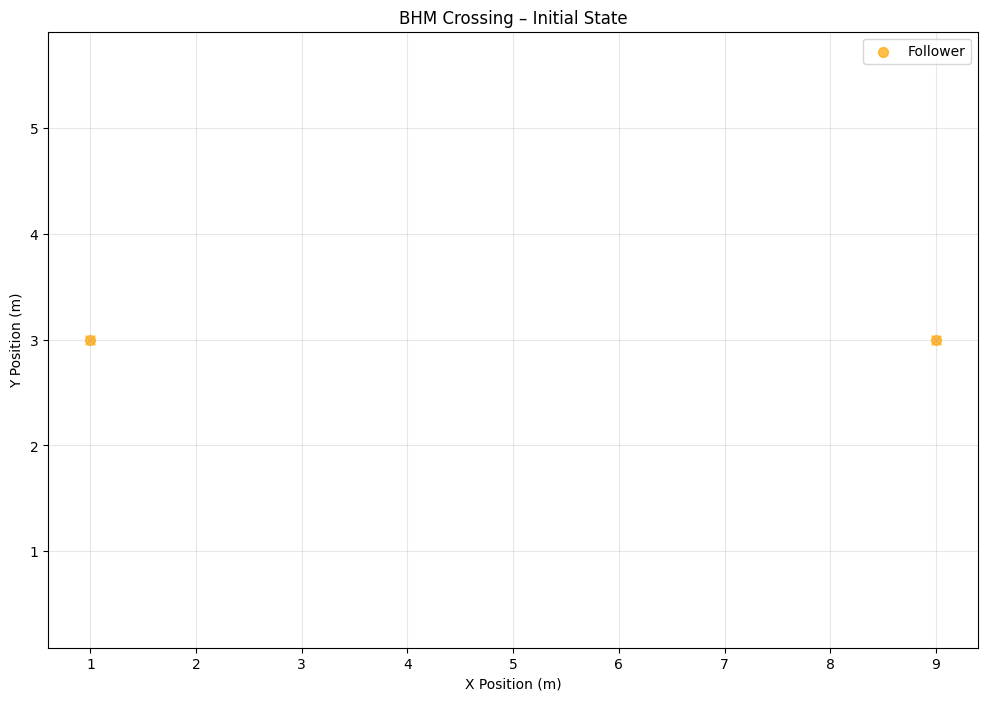

Step 1


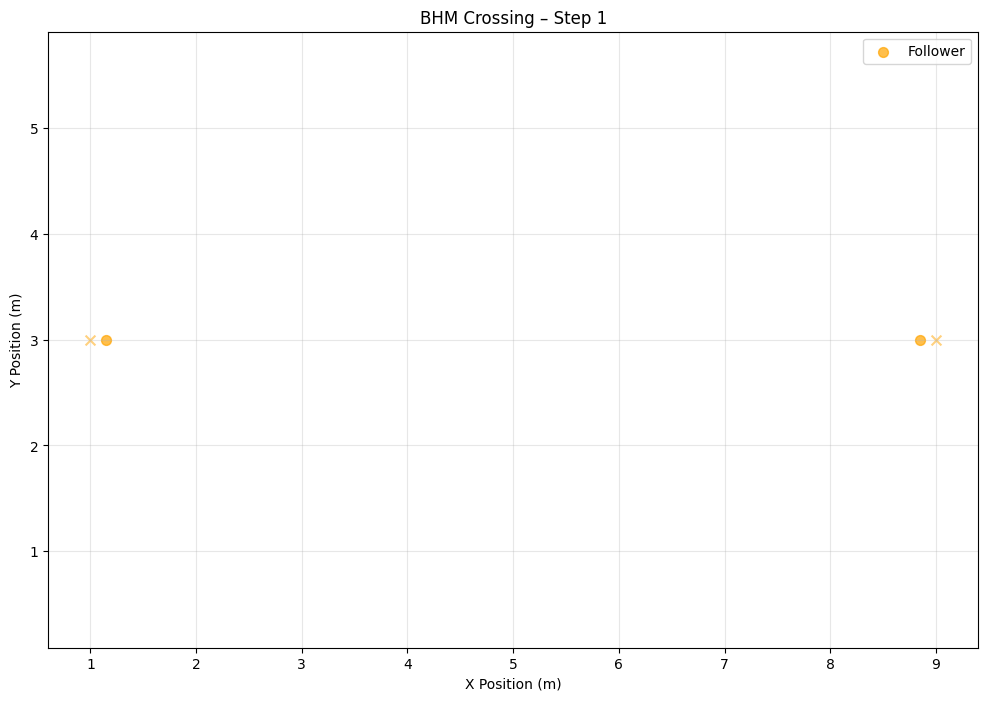

Step 2


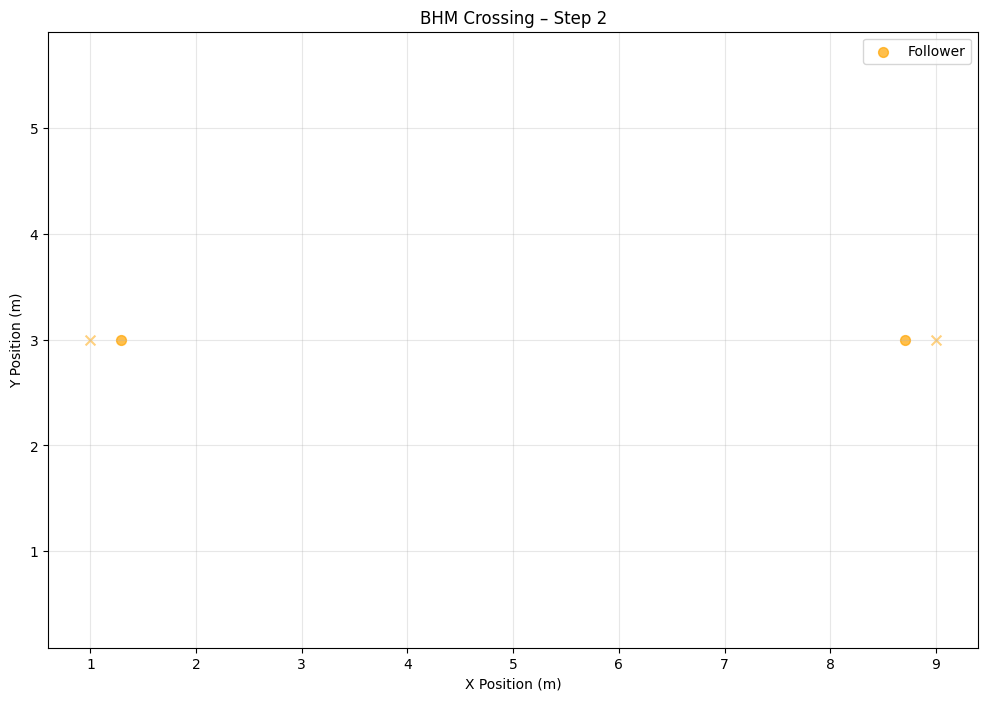

Step 3


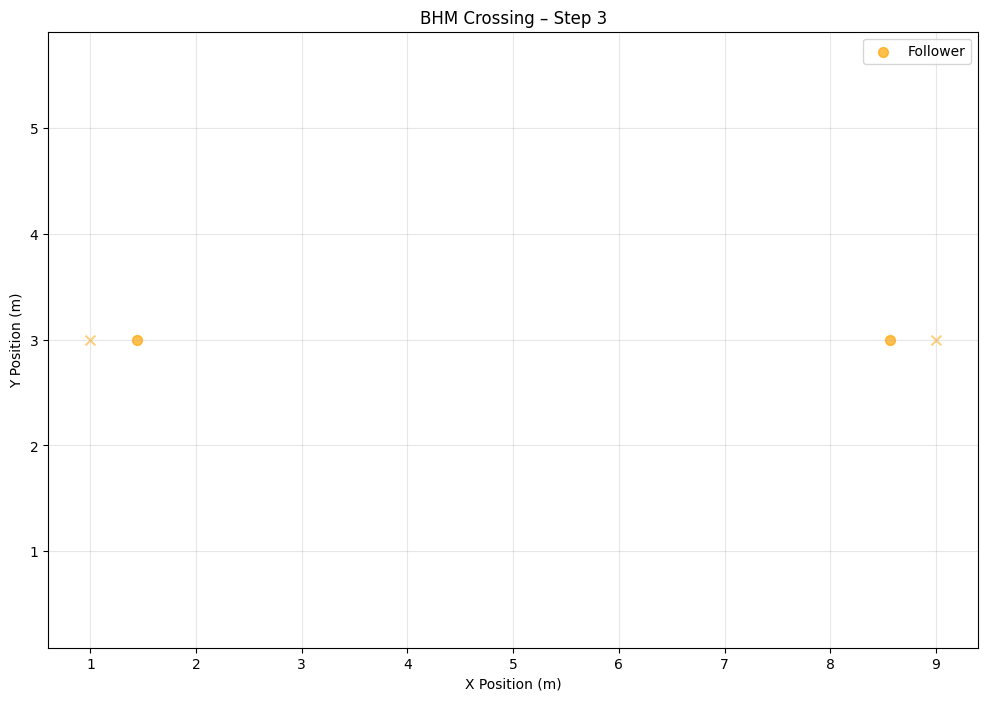

Step 4


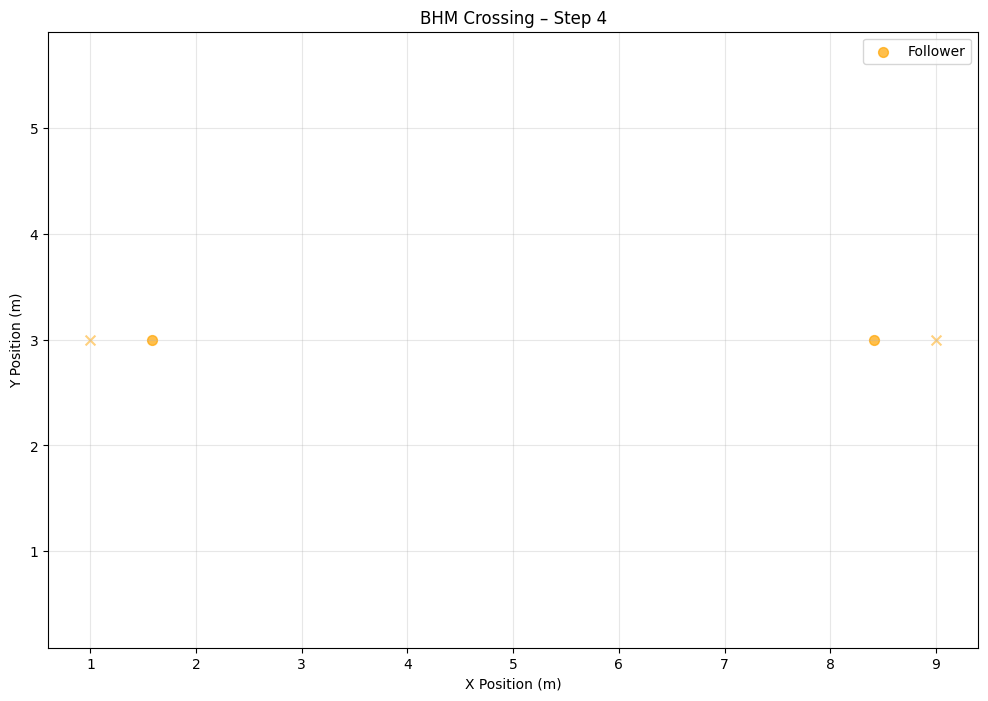

Step 5


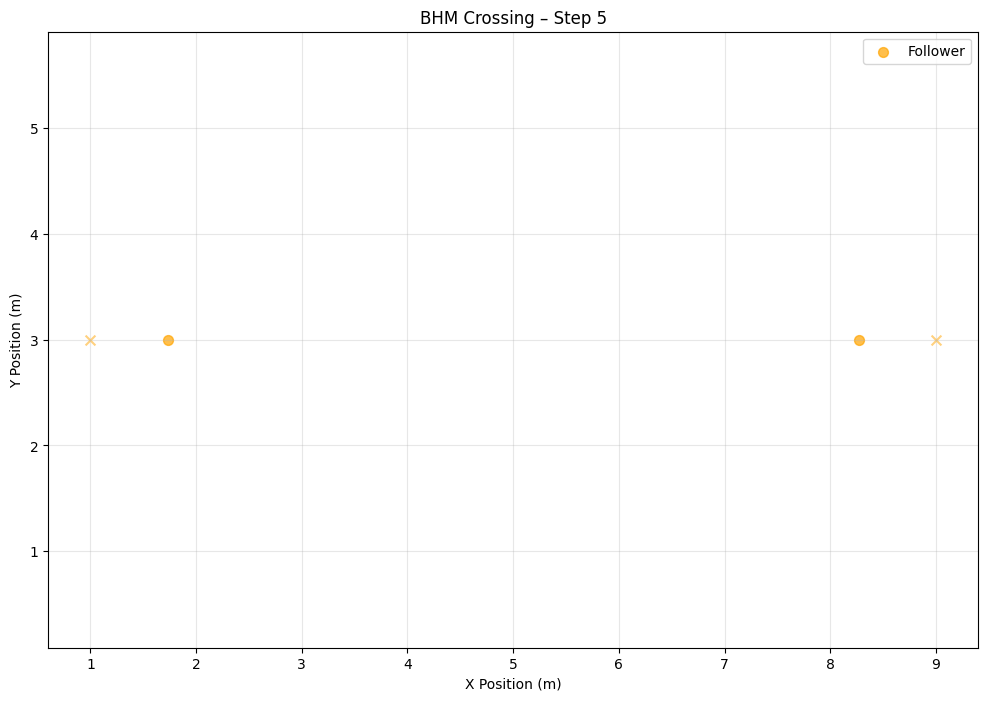

Step 6


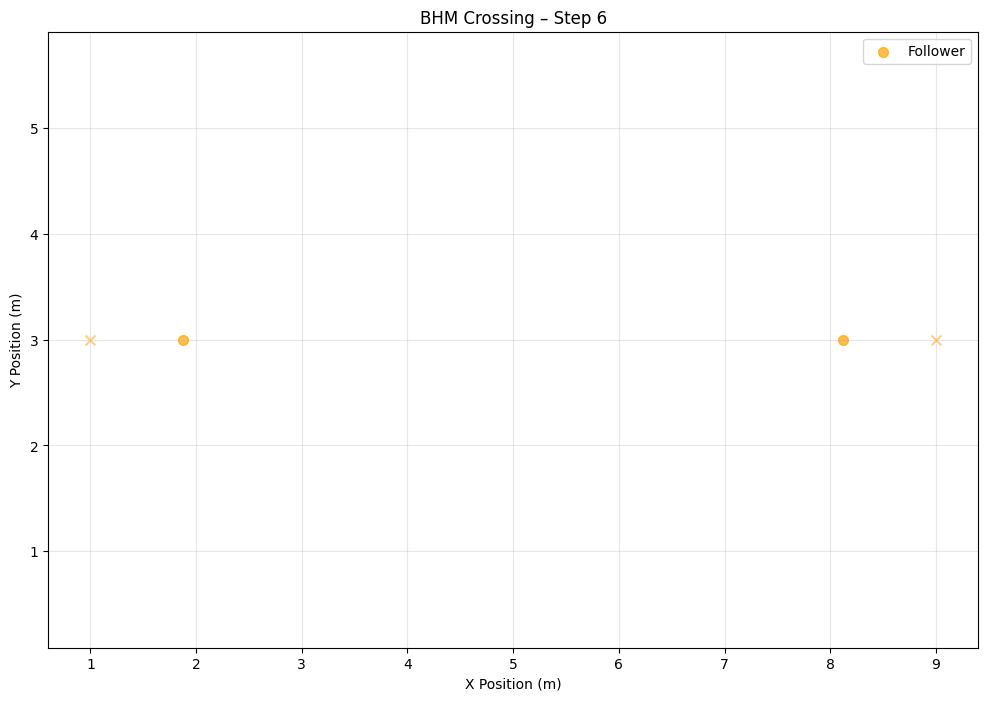

Step 7


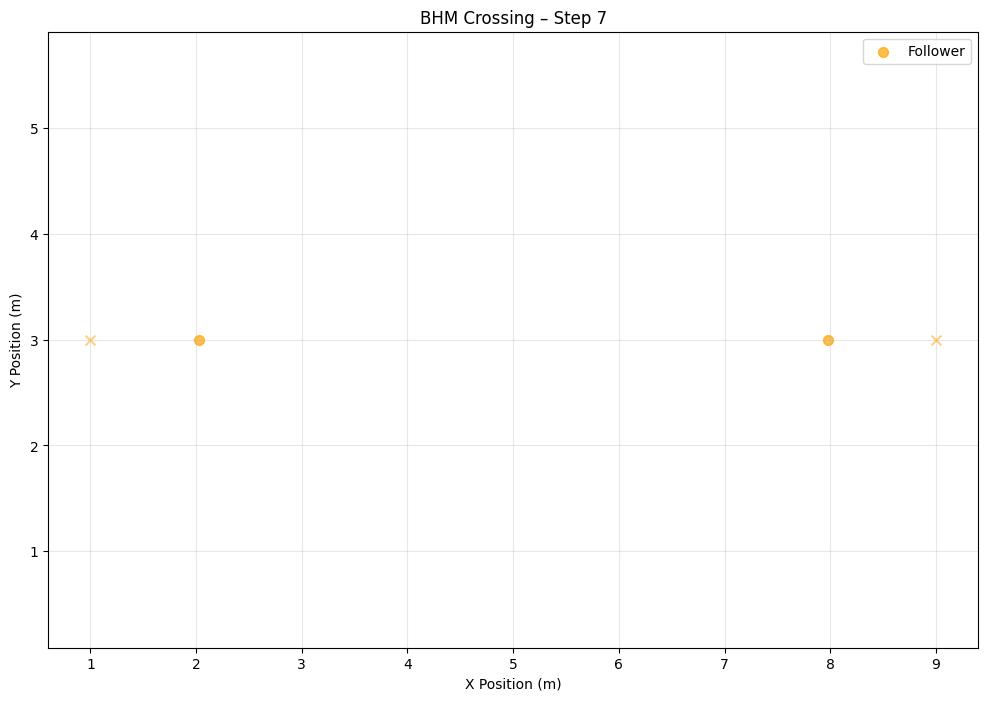

Step 8


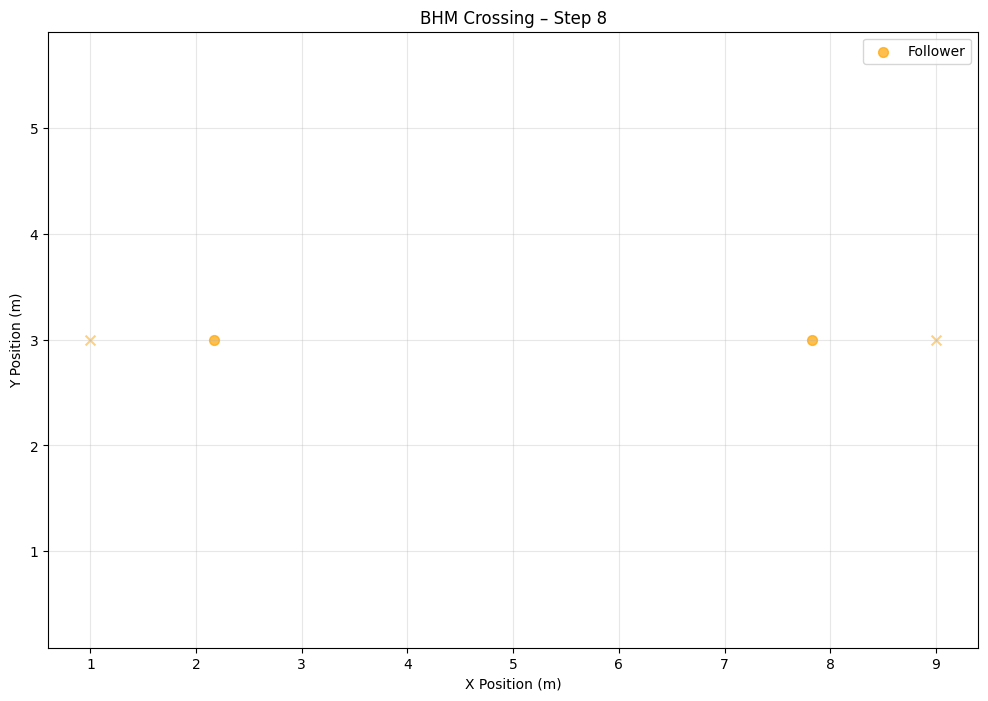

Step 9


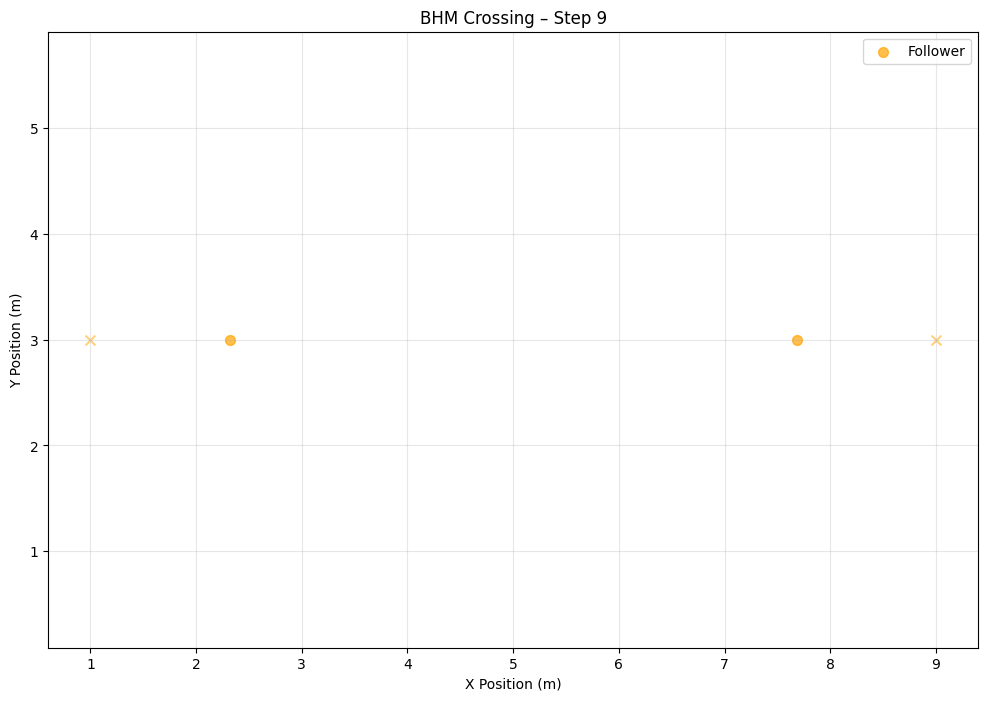

Step 10


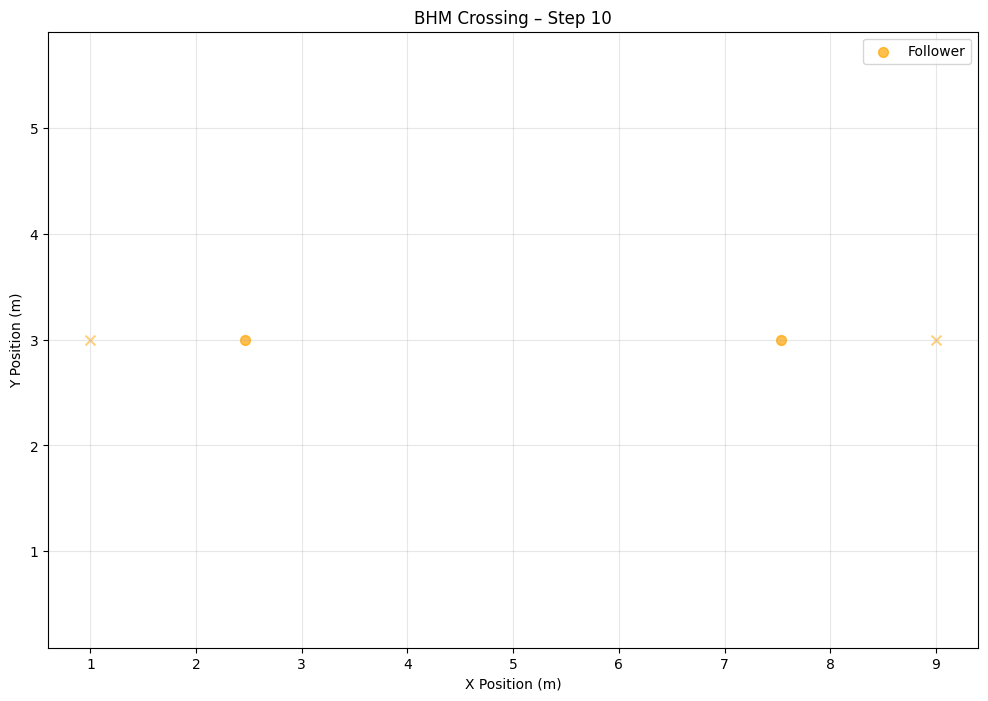

Step 11


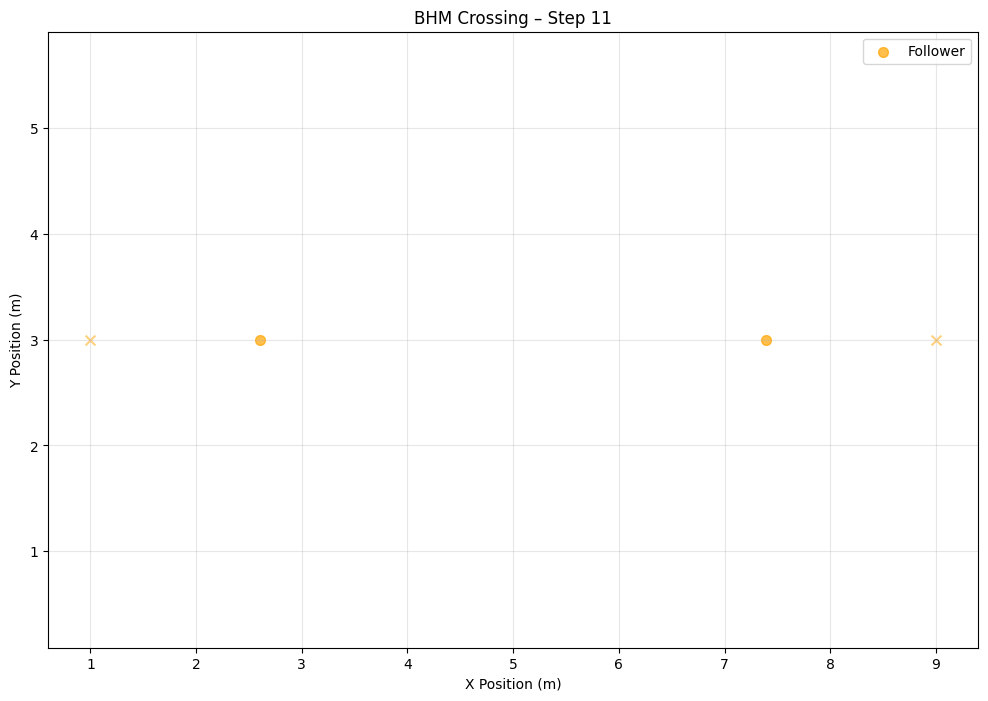

Step 12


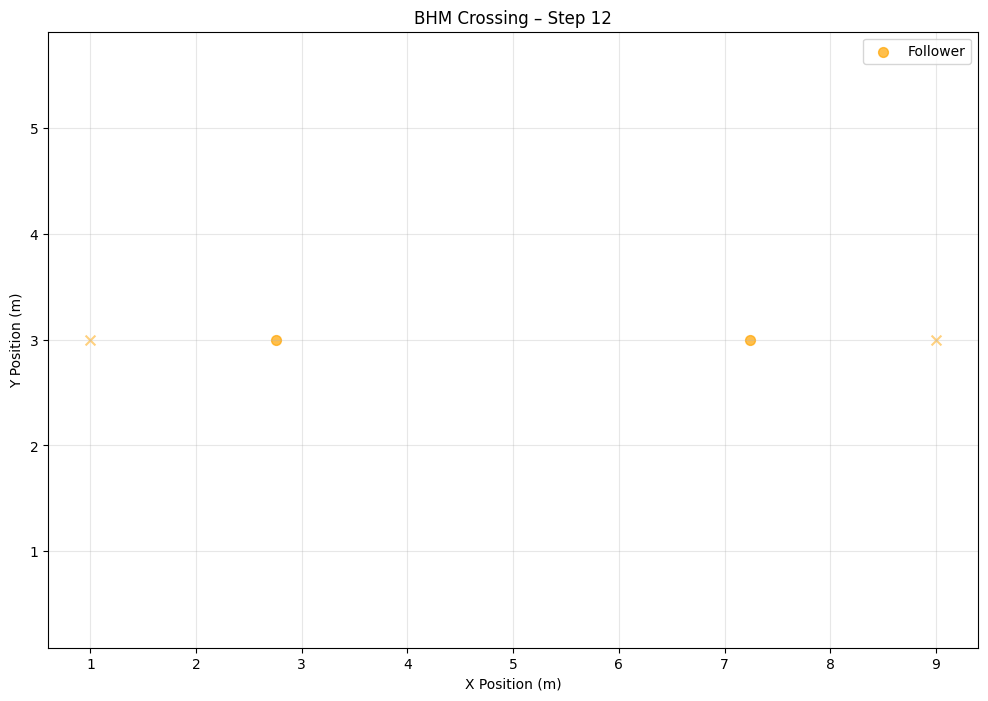

Step 13


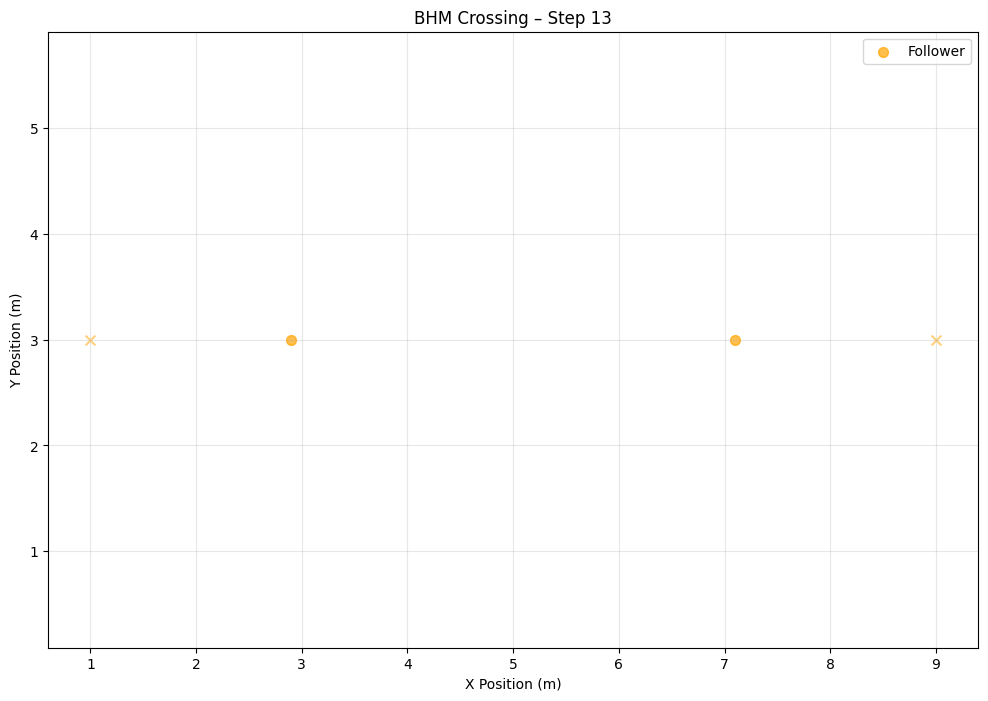

Step 14


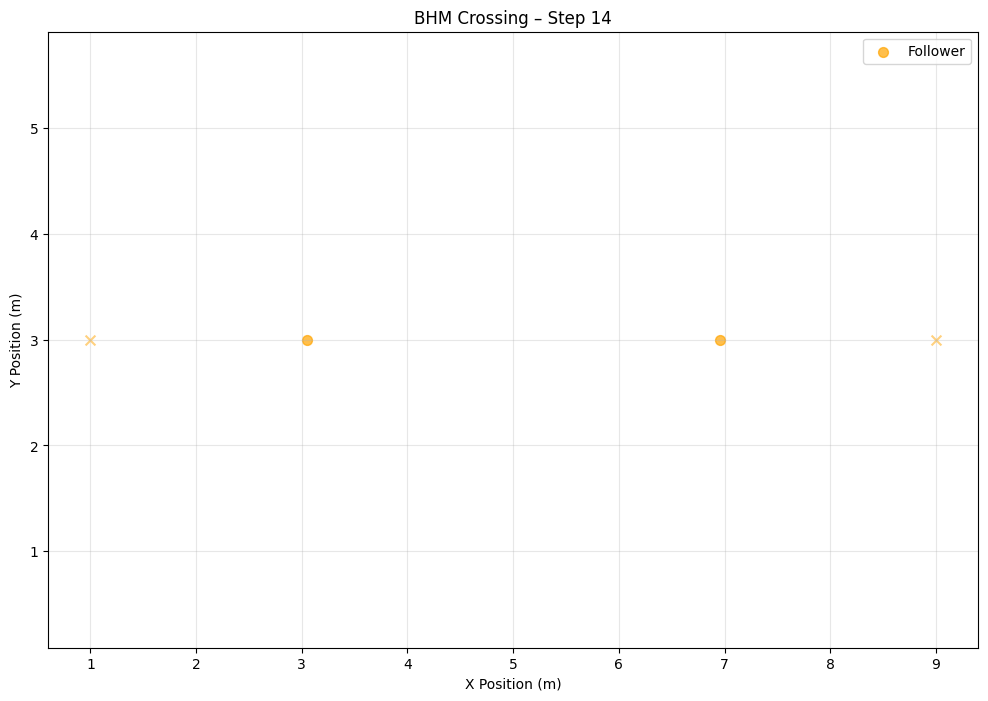

Step 15


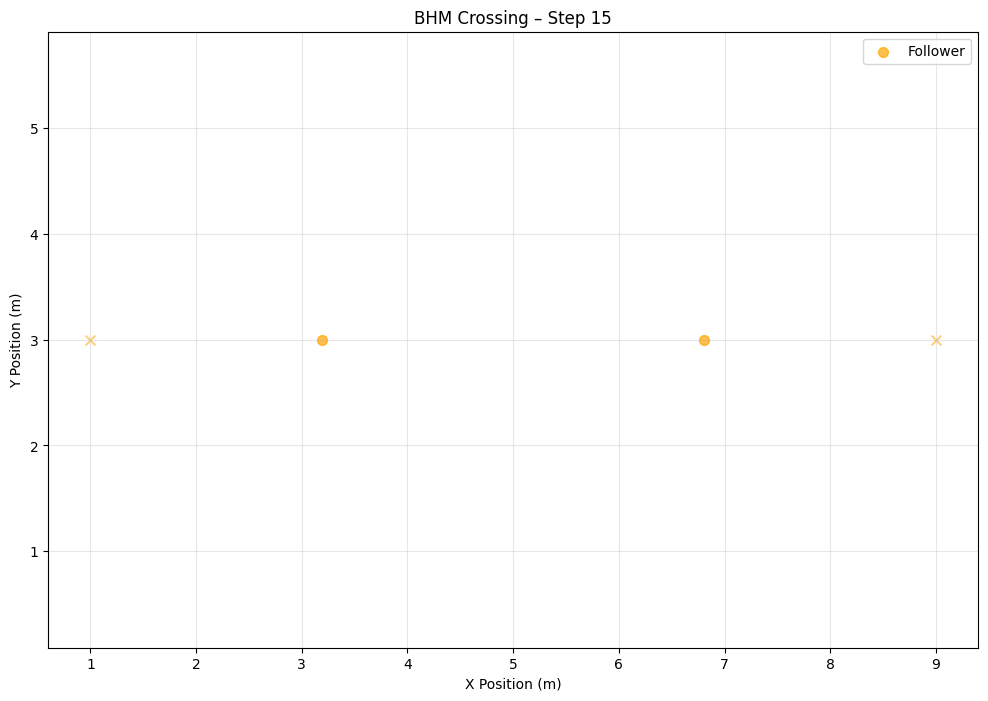

Step 16


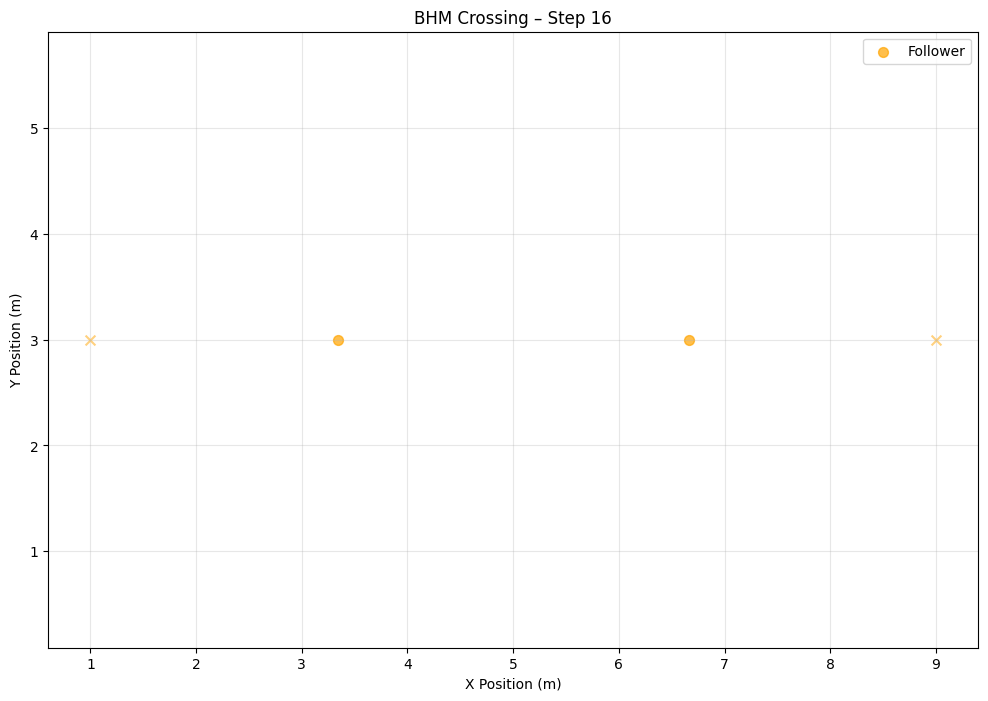

Step 17


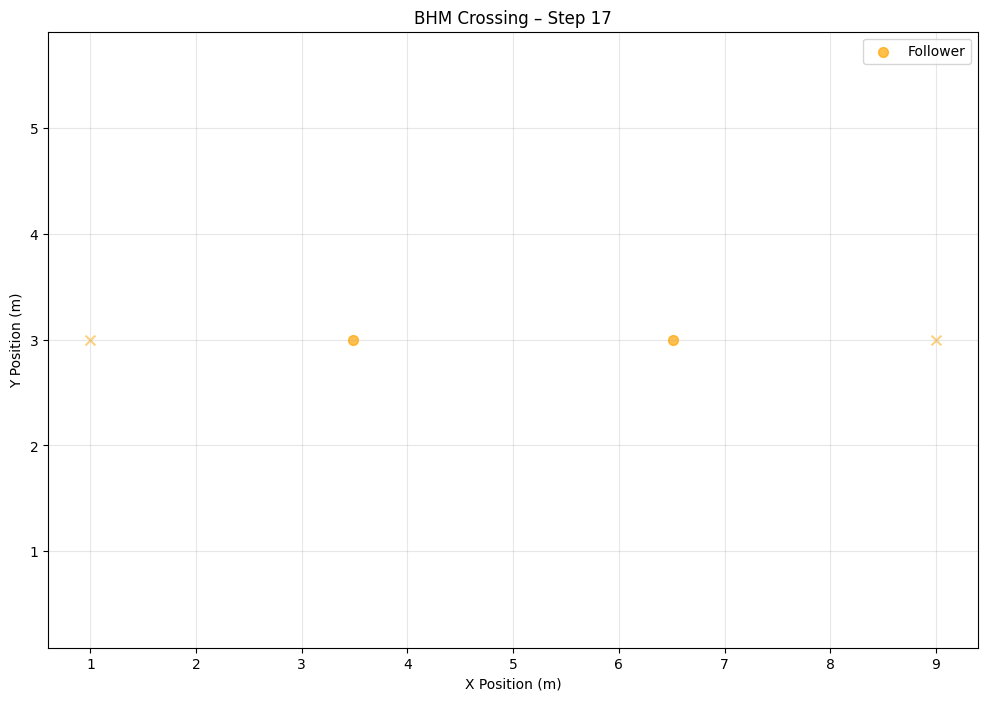

Step 18


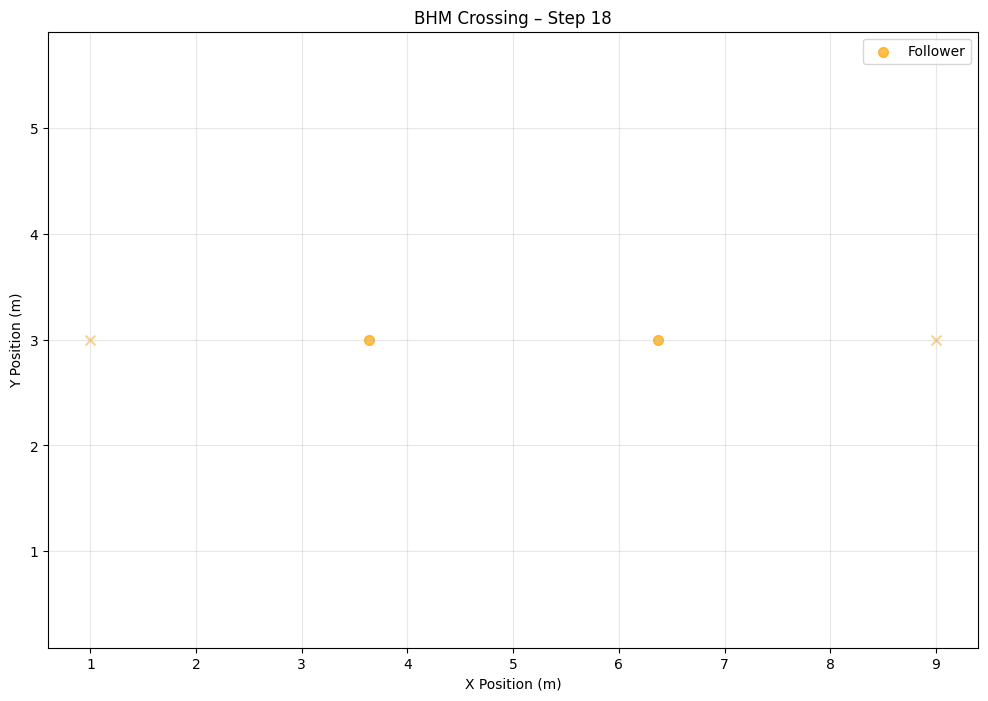

Step 19


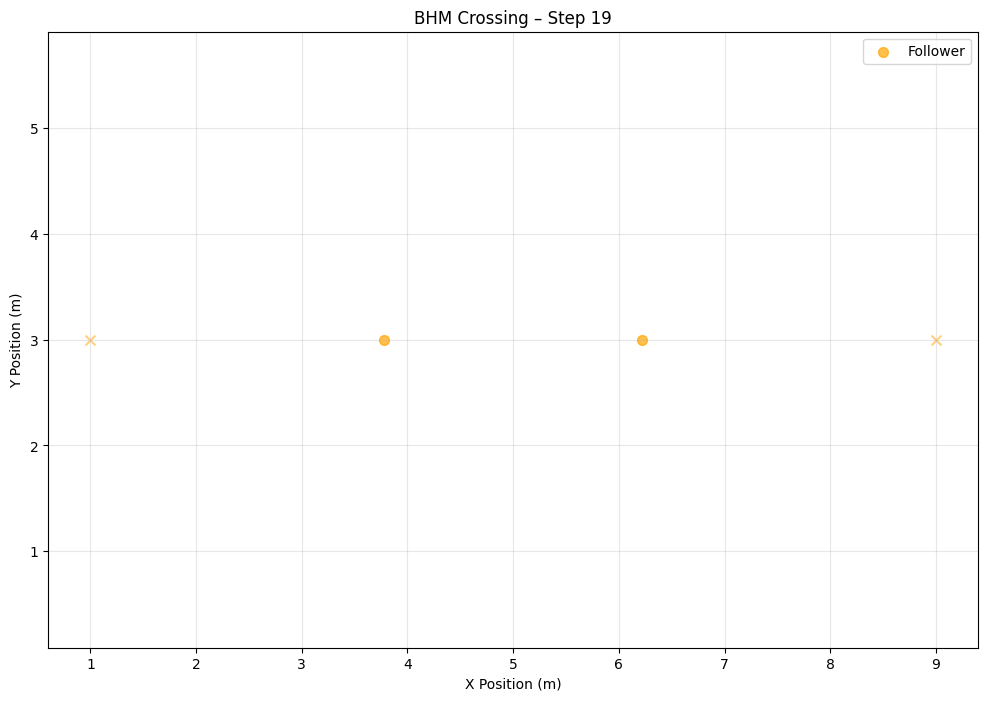

Step 20


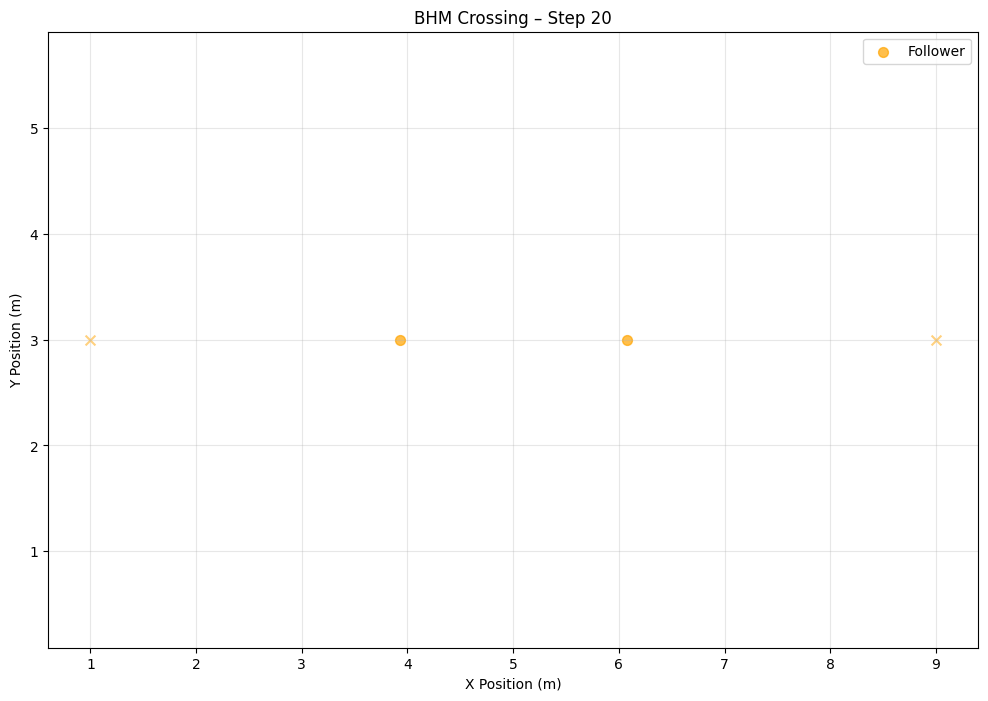

Step 21


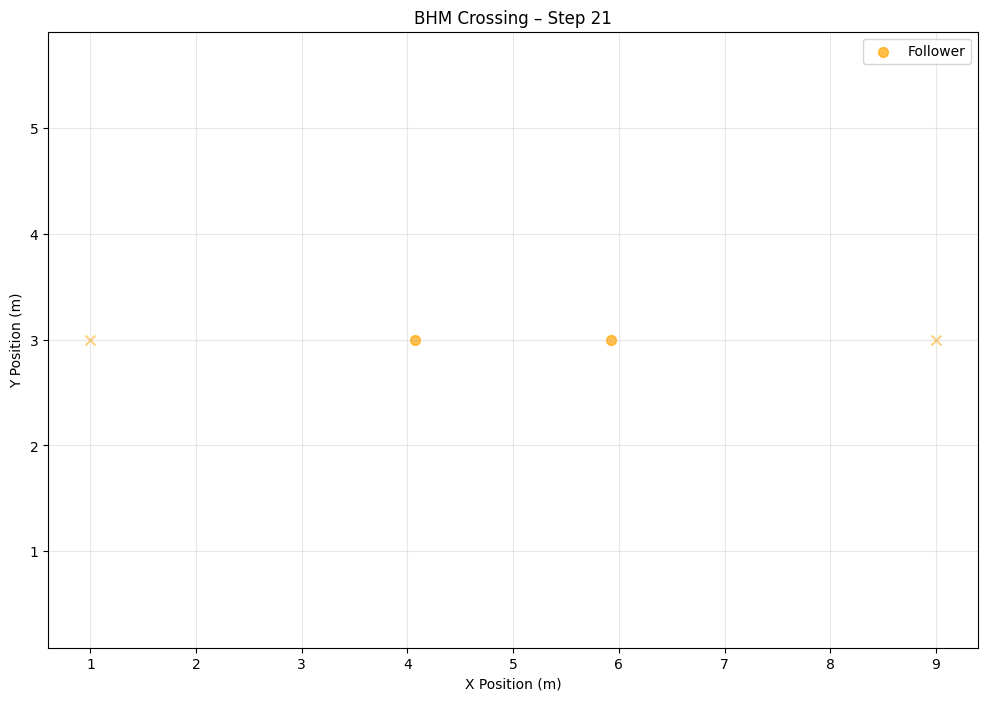

Step 22


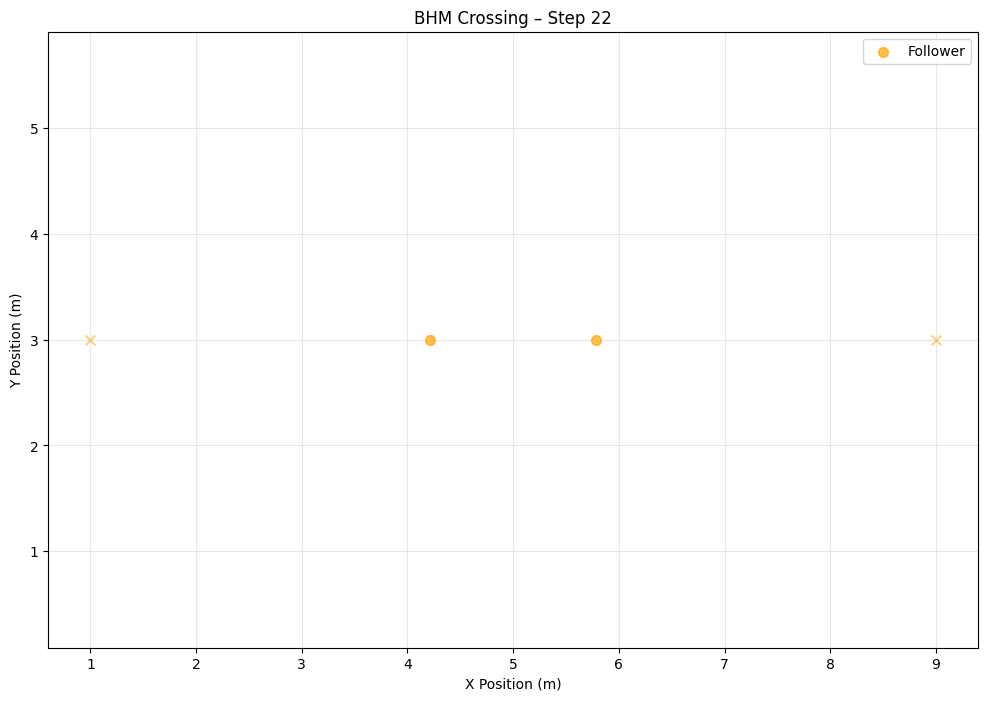

Step 23


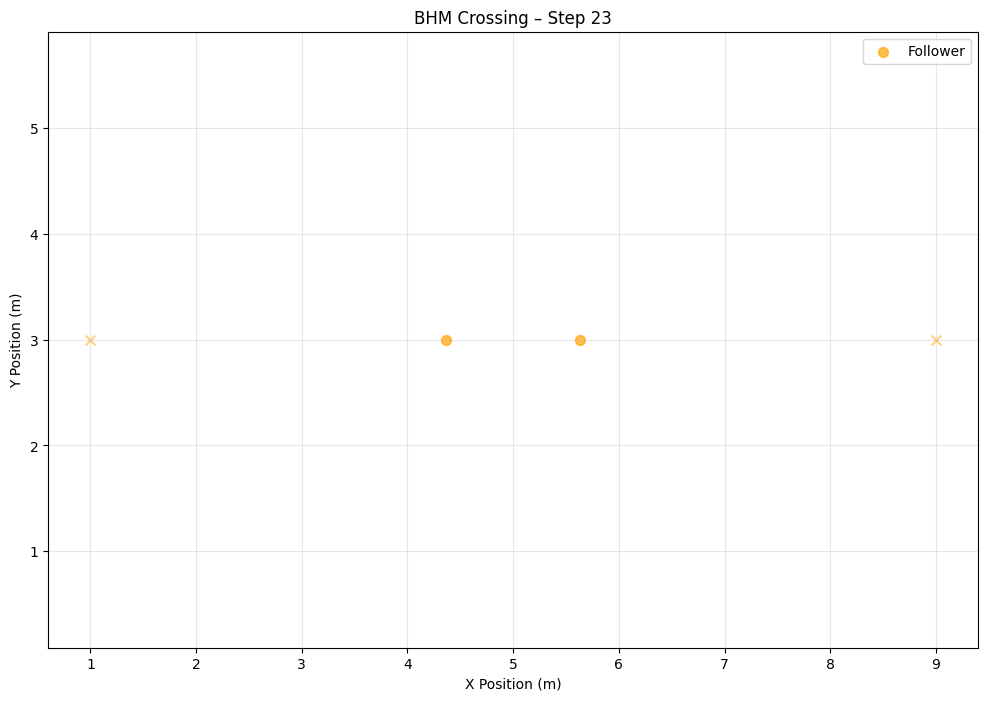

Step 24


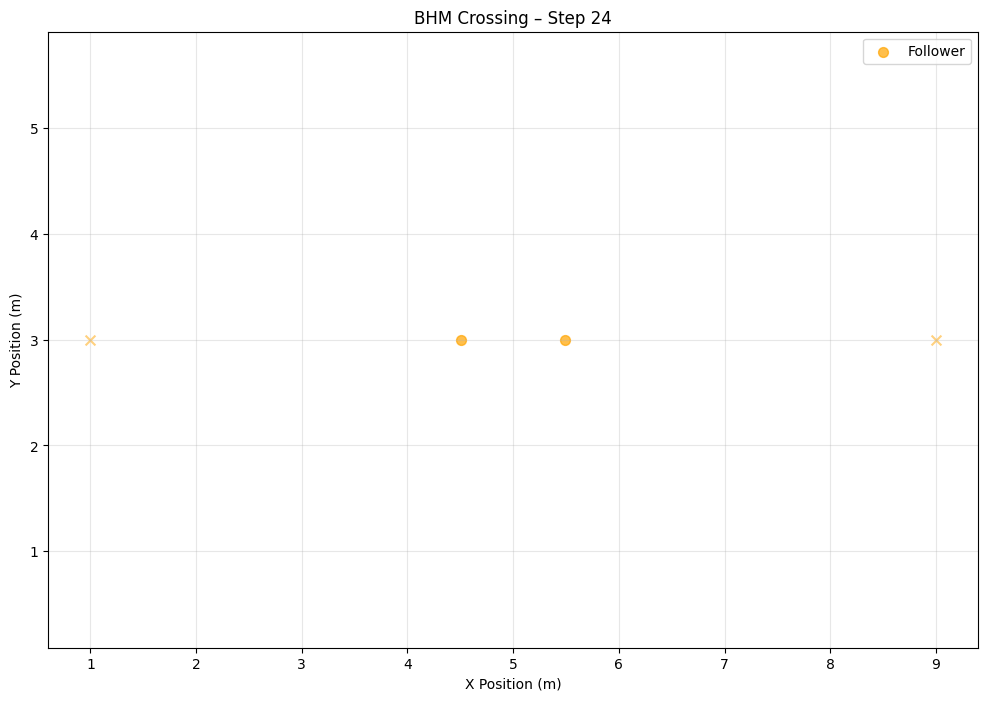

Step 25


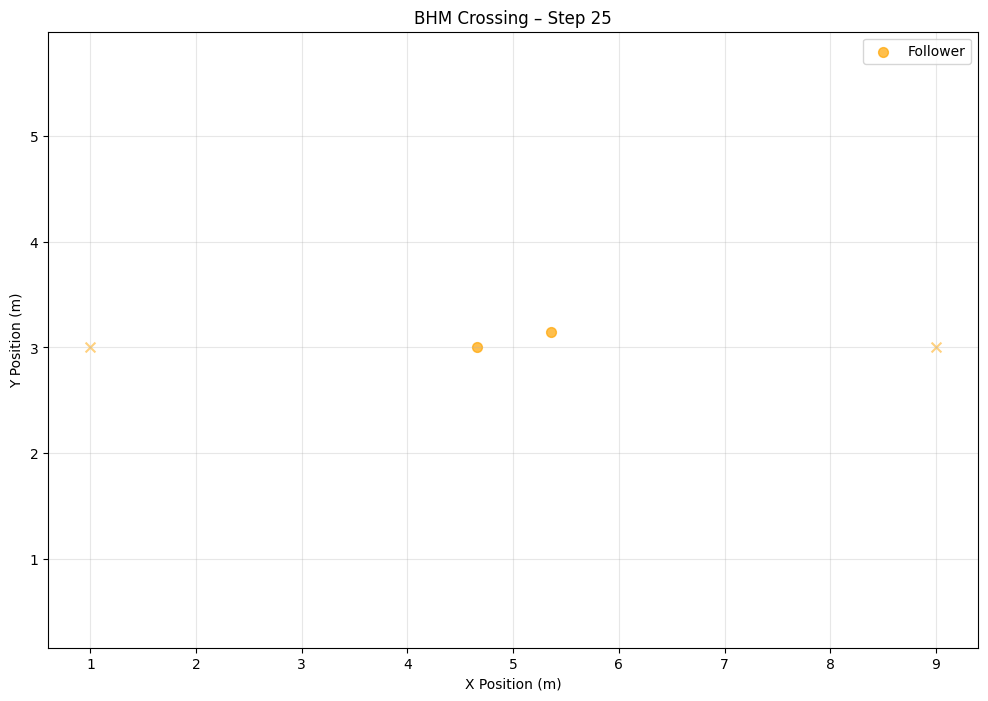

Step 26


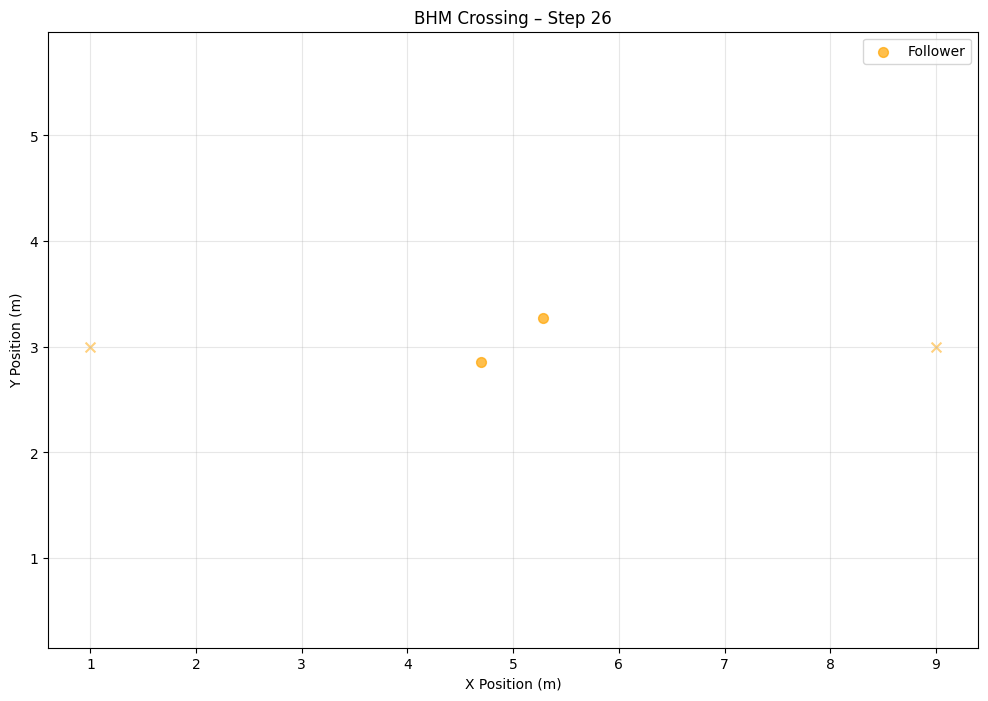

Step 27


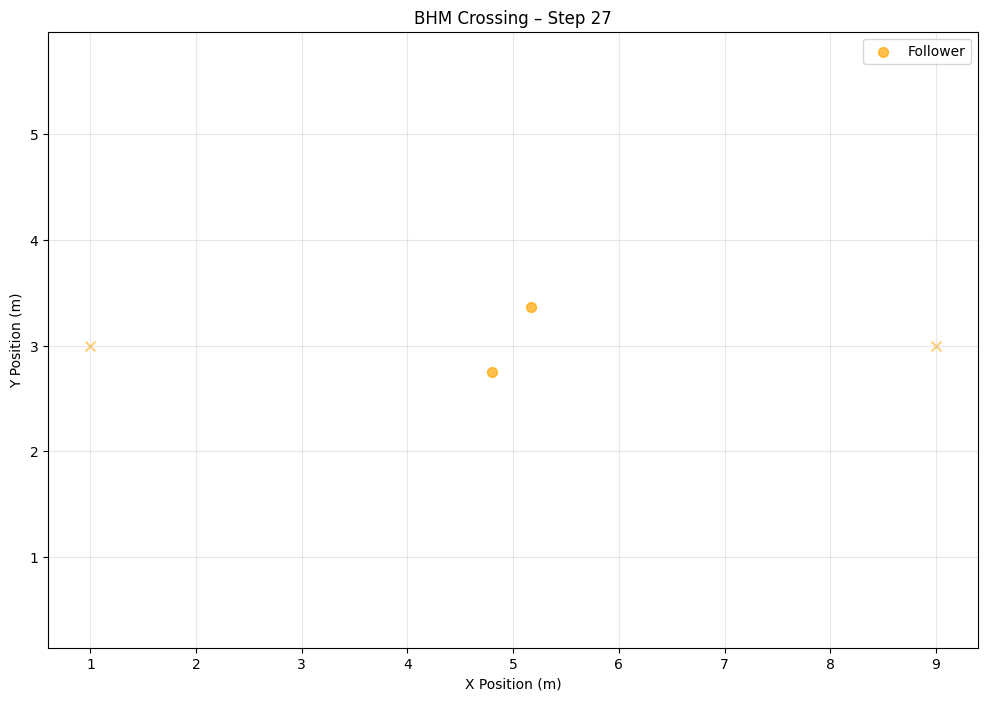

Step 28


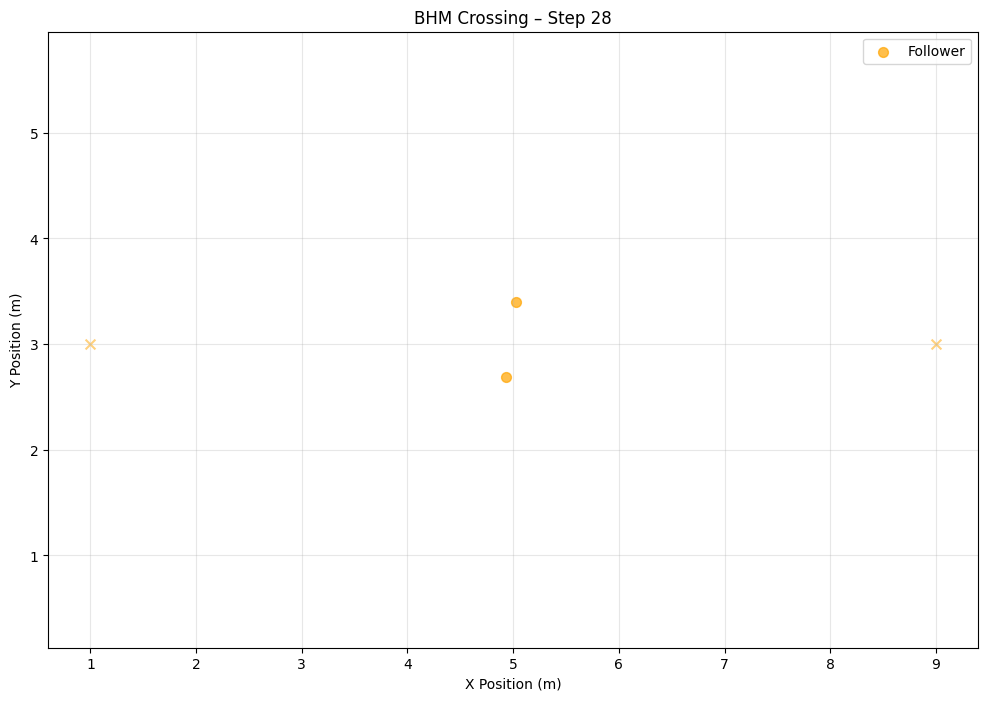

Step 29


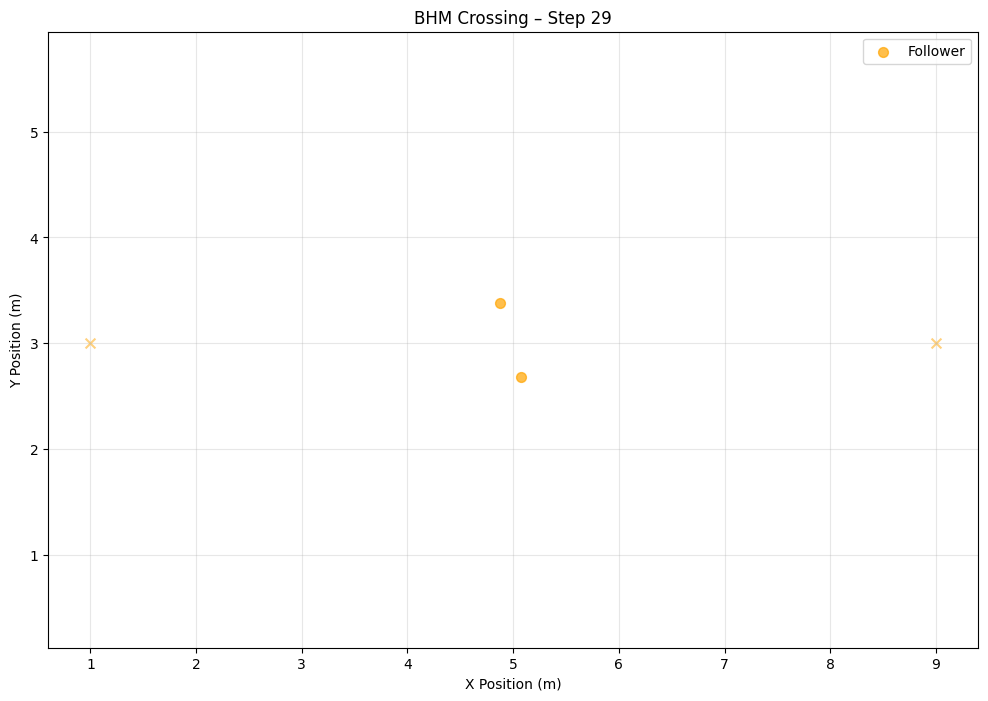

Step 30


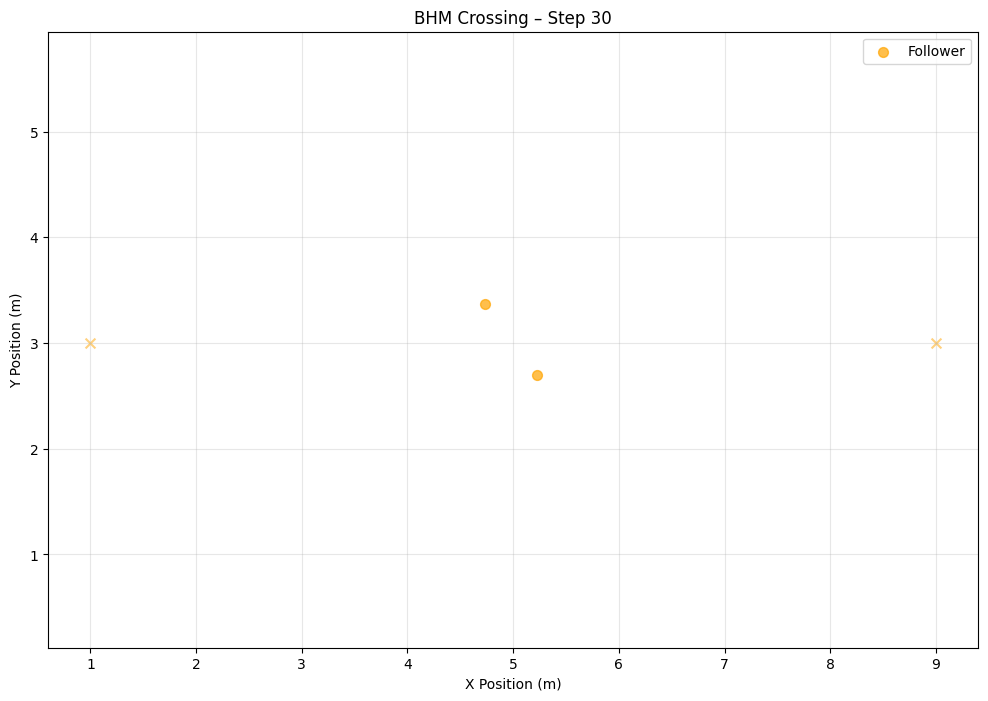

Step 31


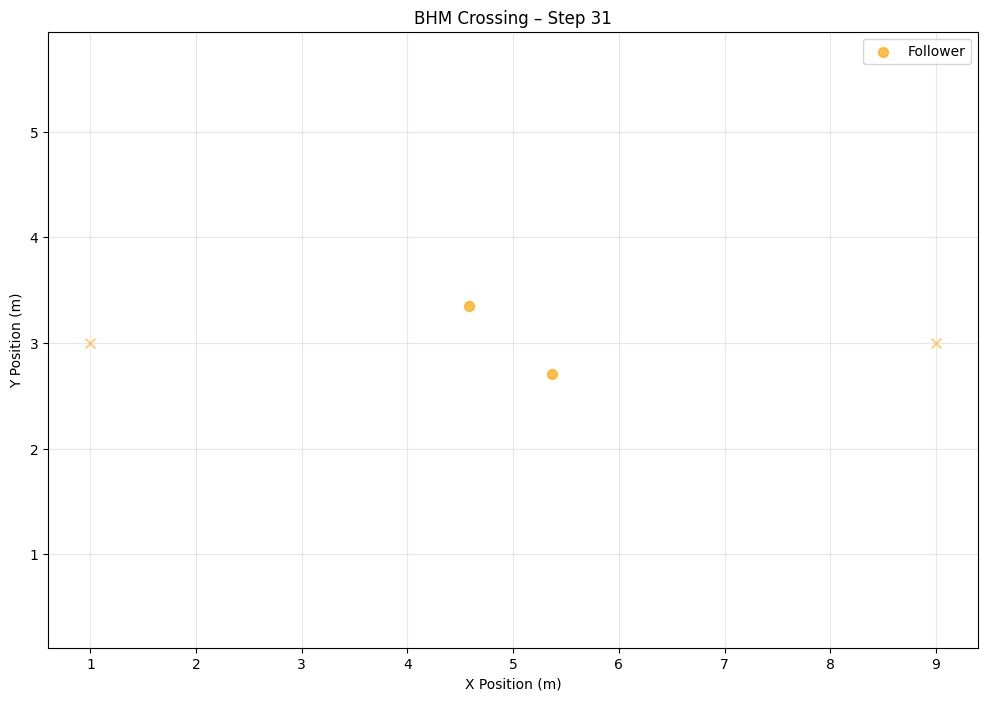

Step 32


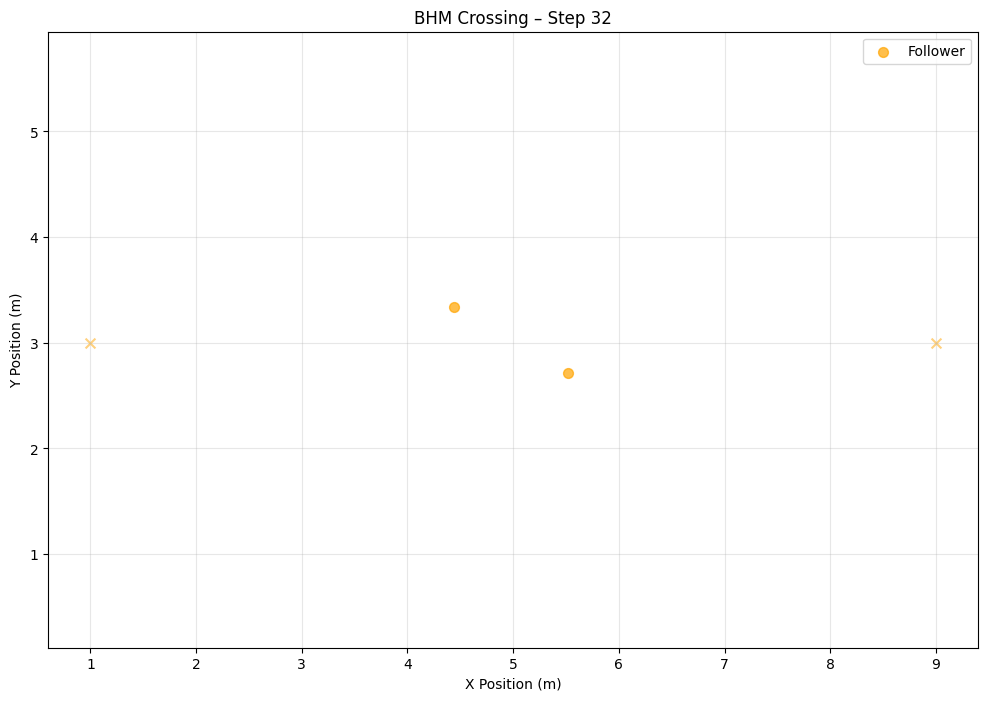

Step 33


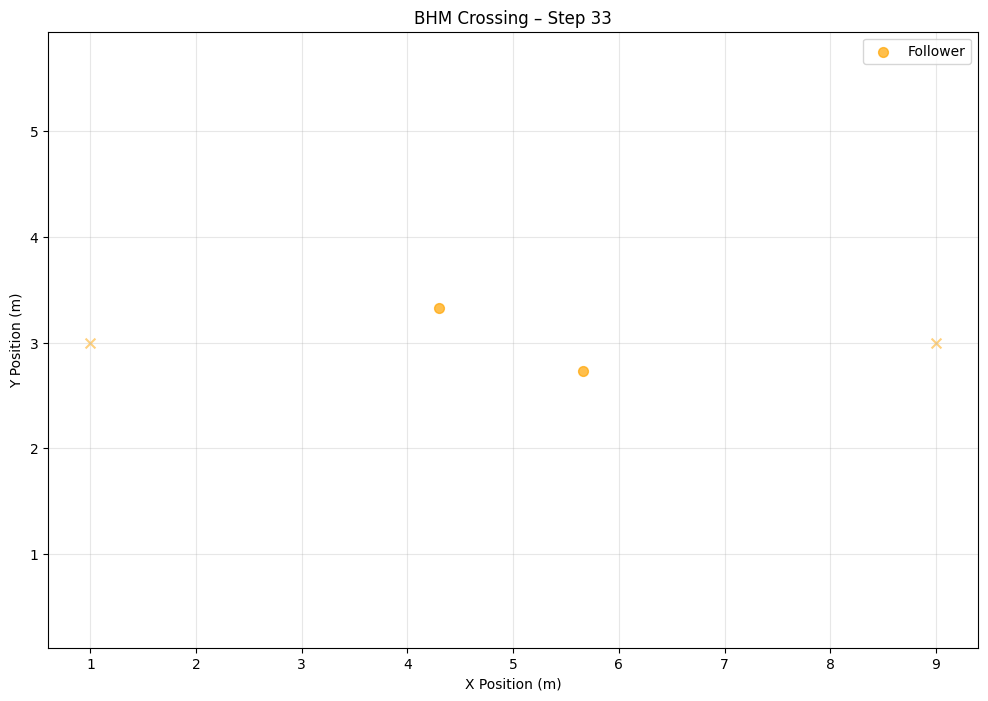

Step 34


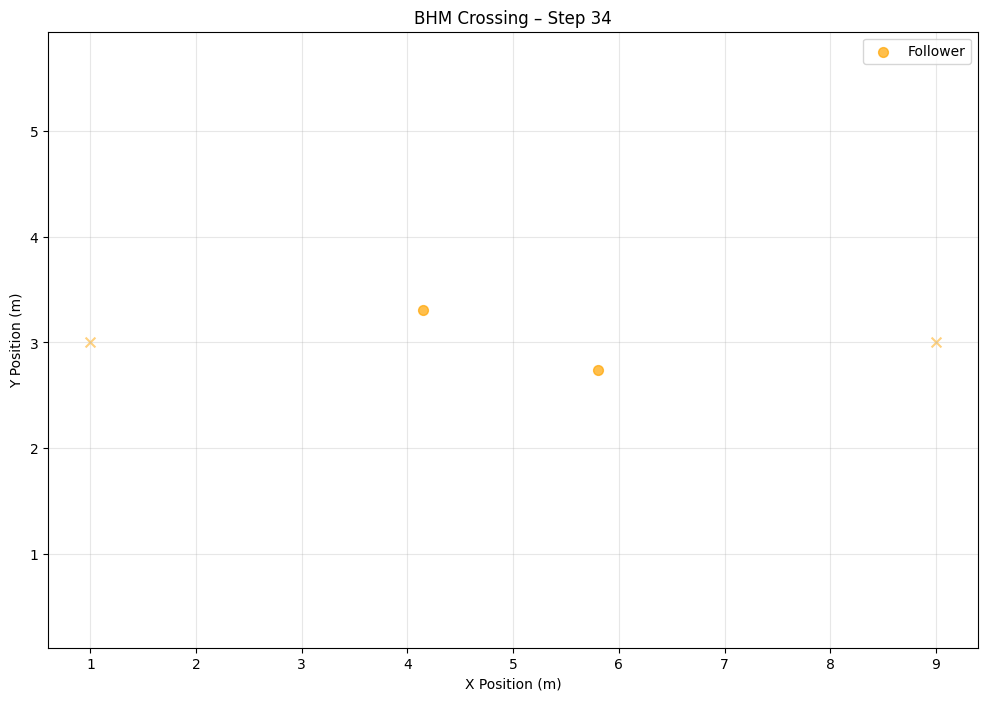

Step 35


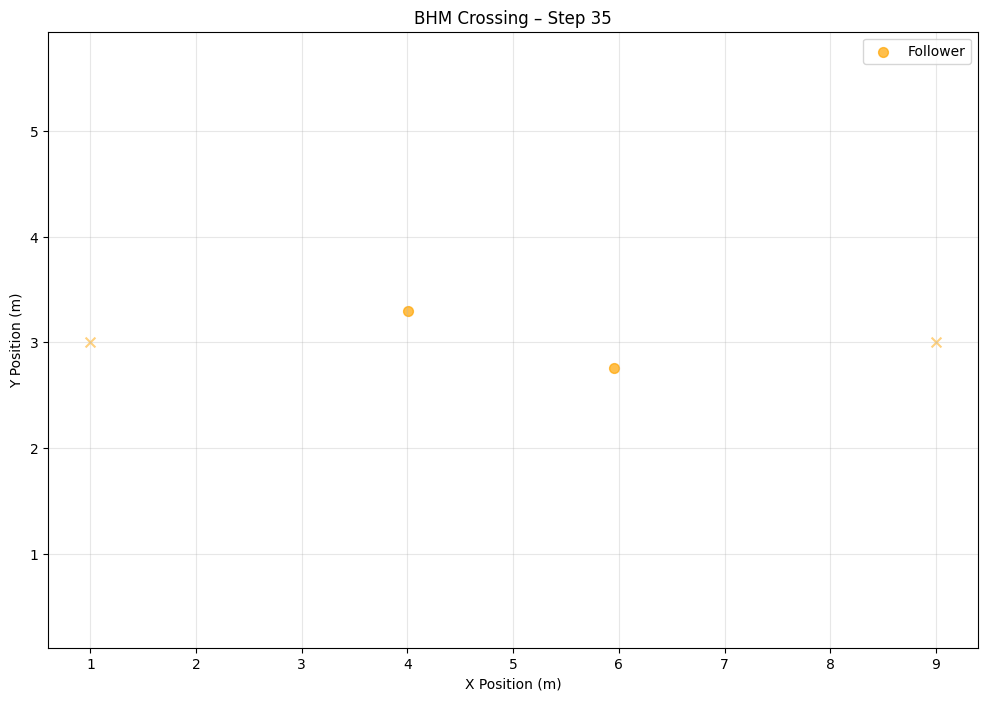

Step 36


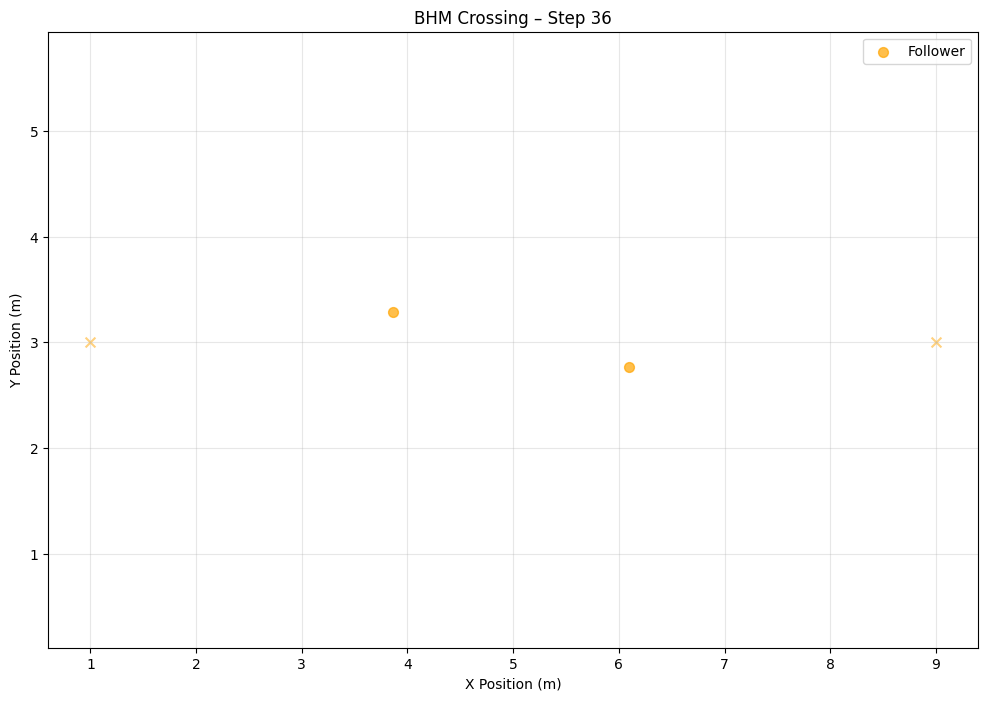

Step 37


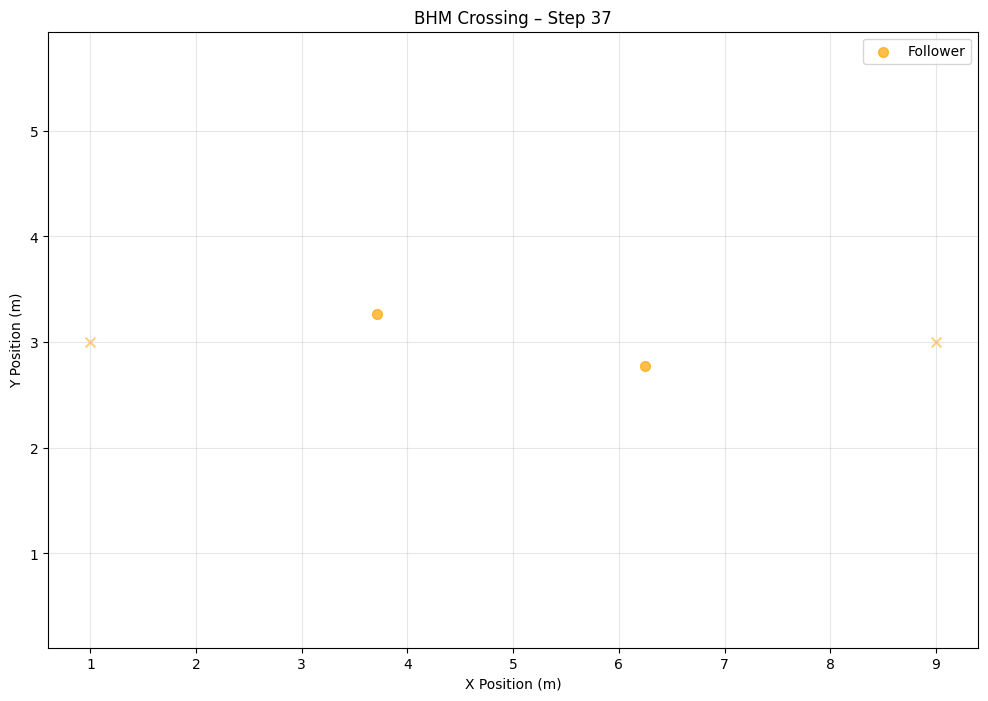

Step 38


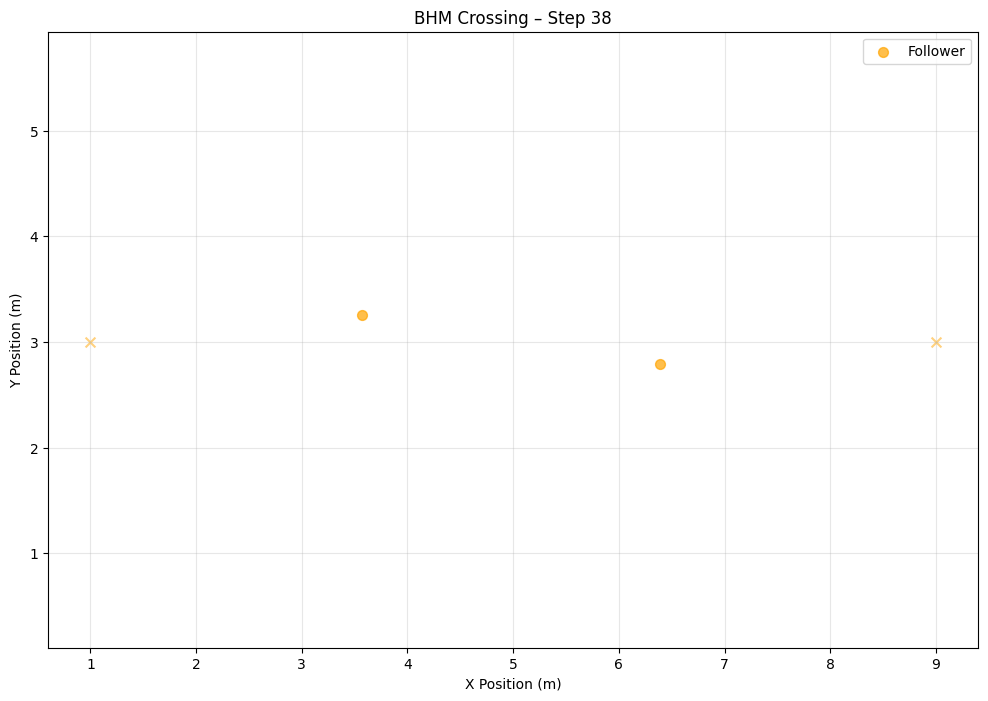

Step 39


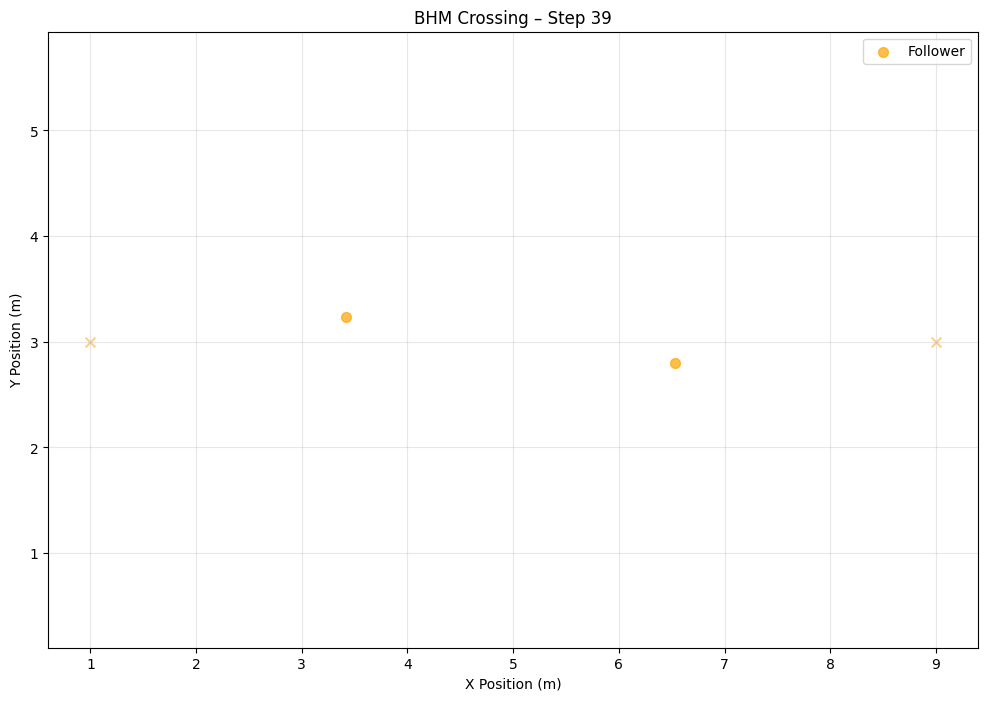

Step 40


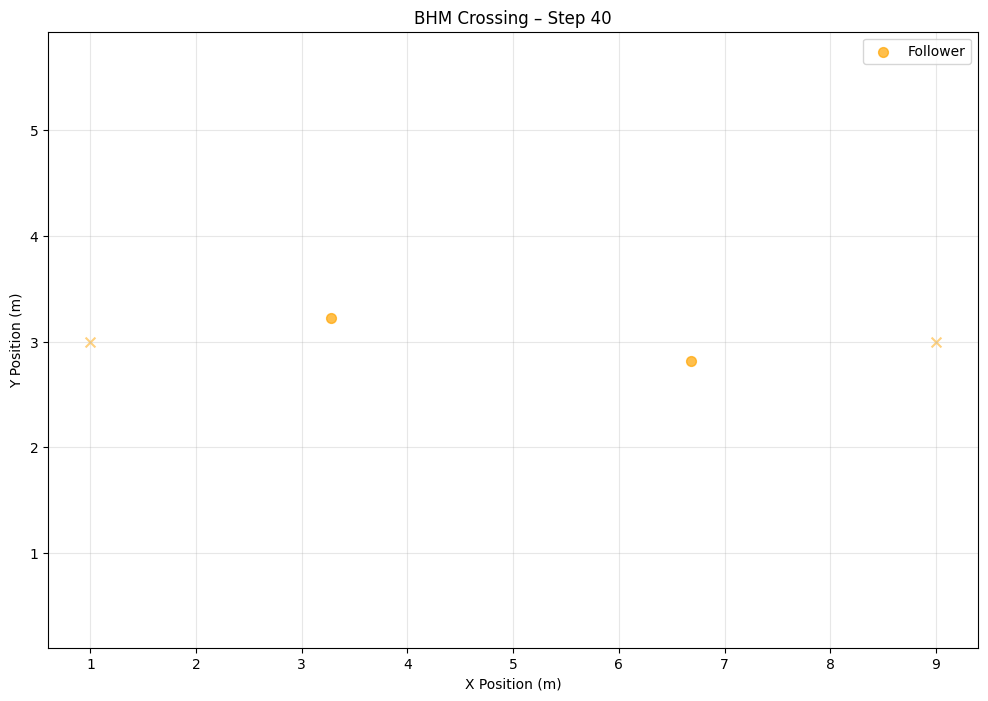

Step 41


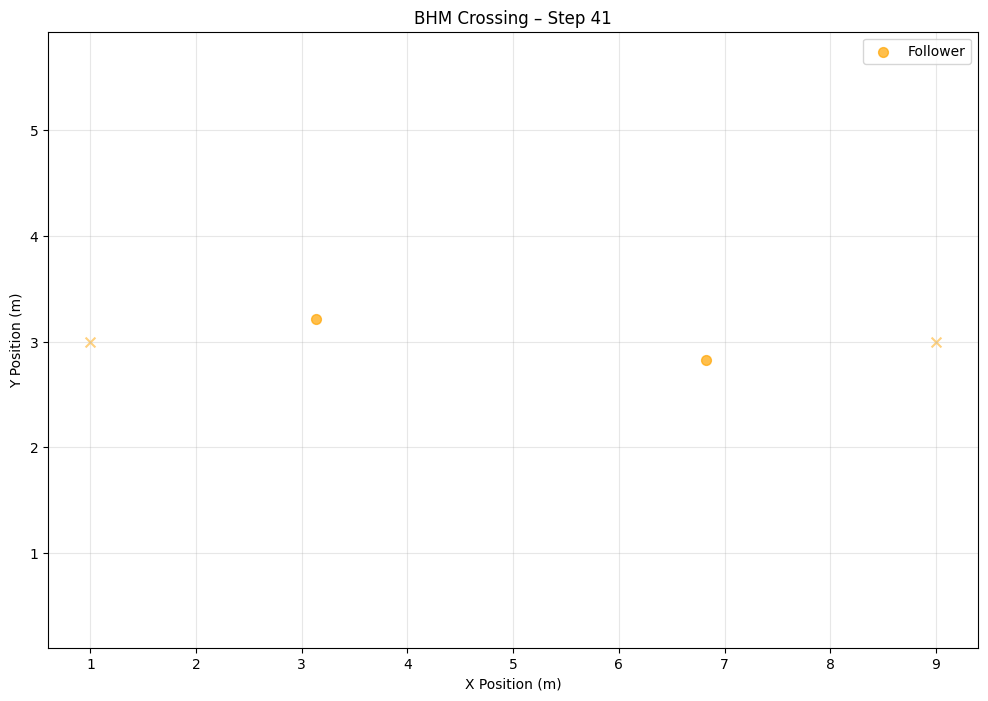

Step 42


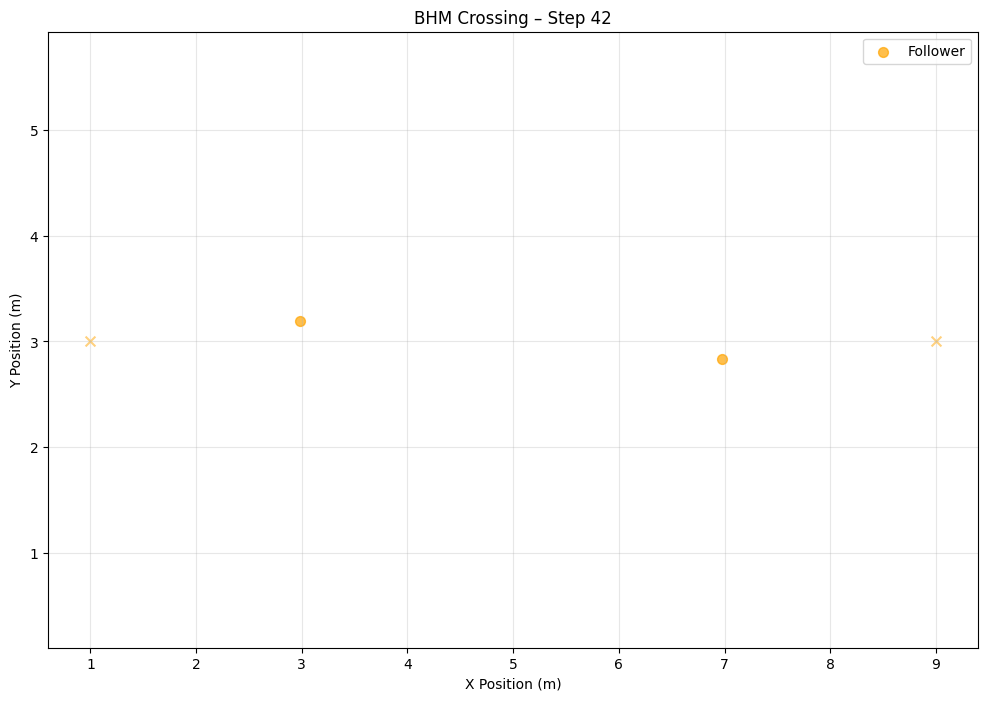

Step 43


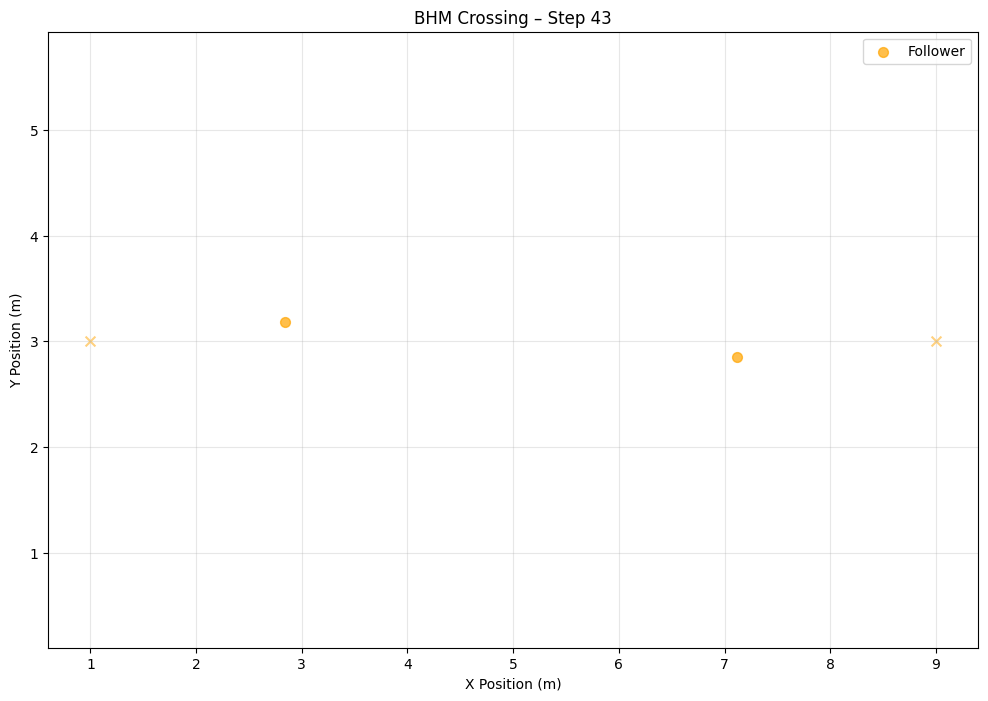

Step 44


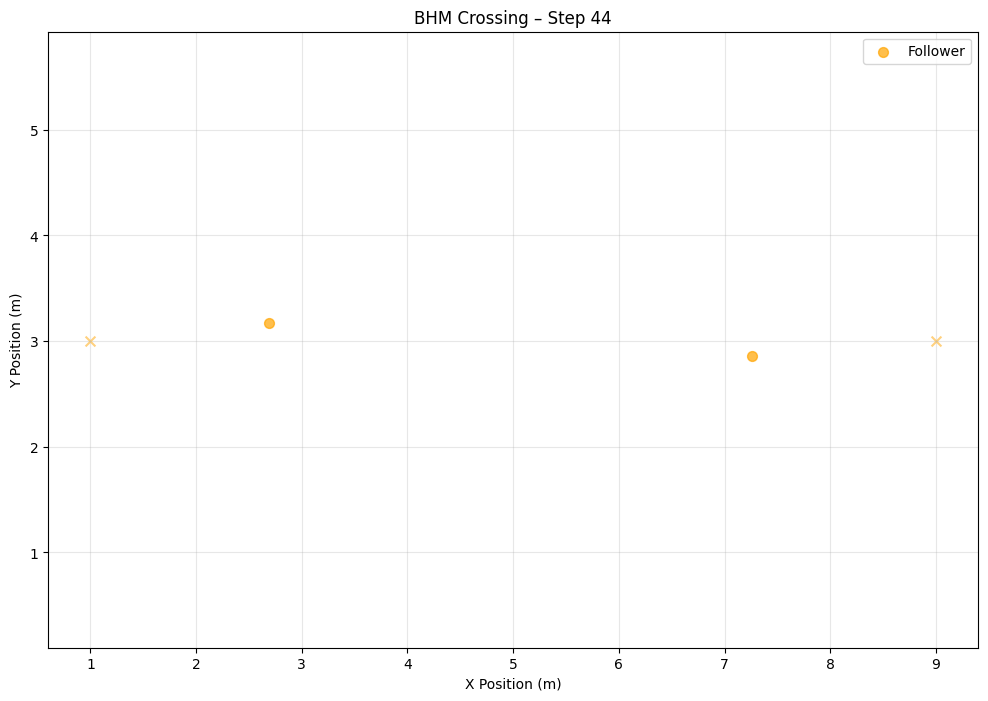

Step 45


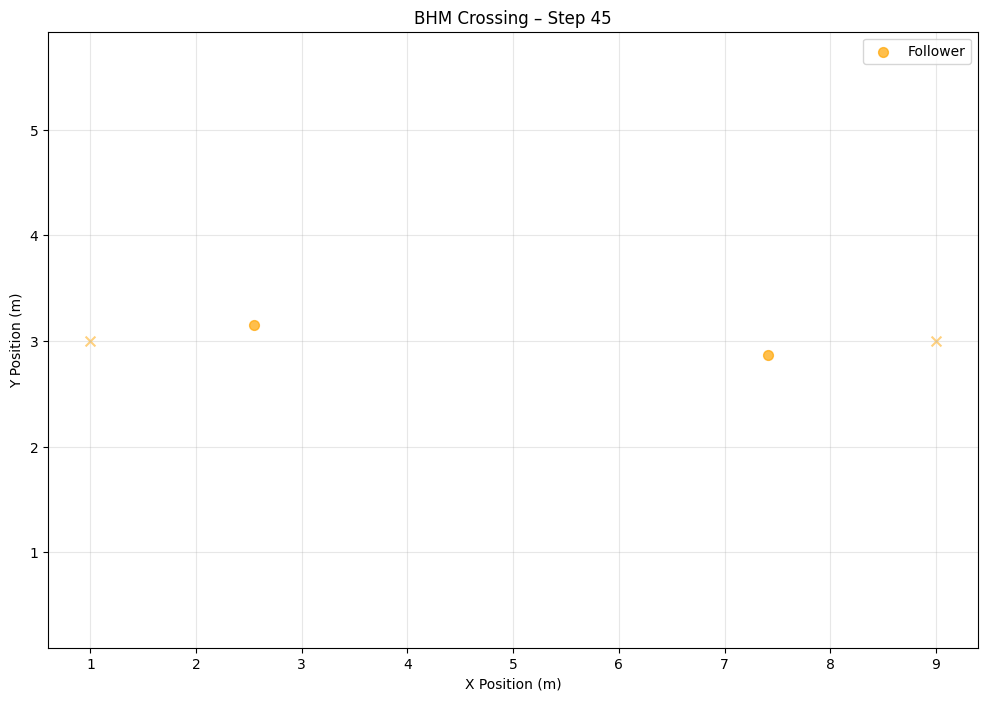

Step 46


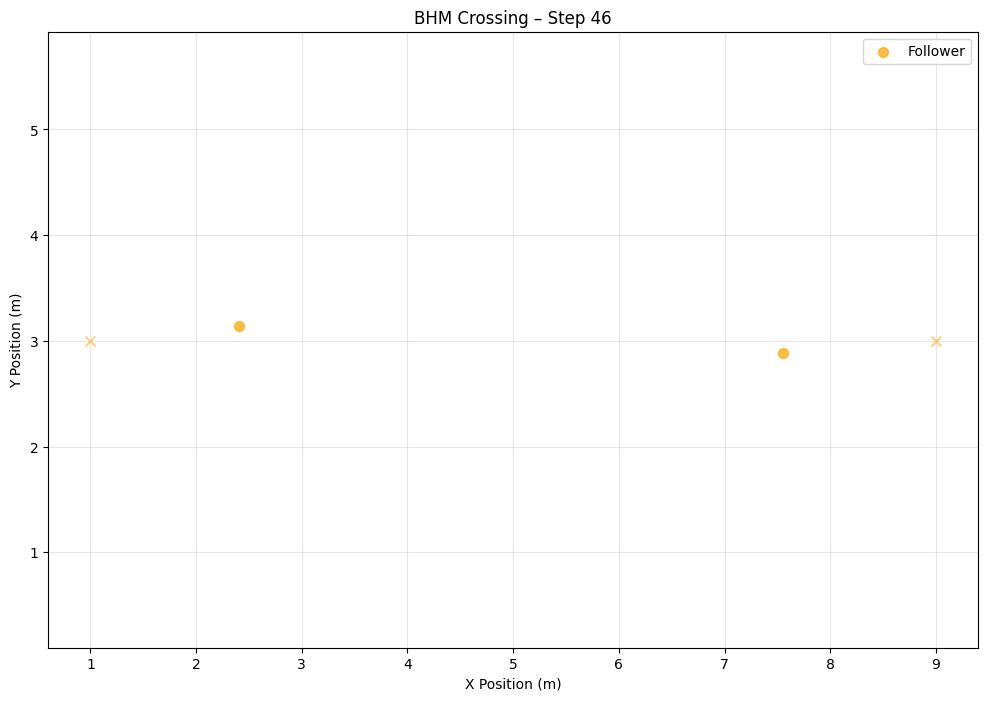

Step 47


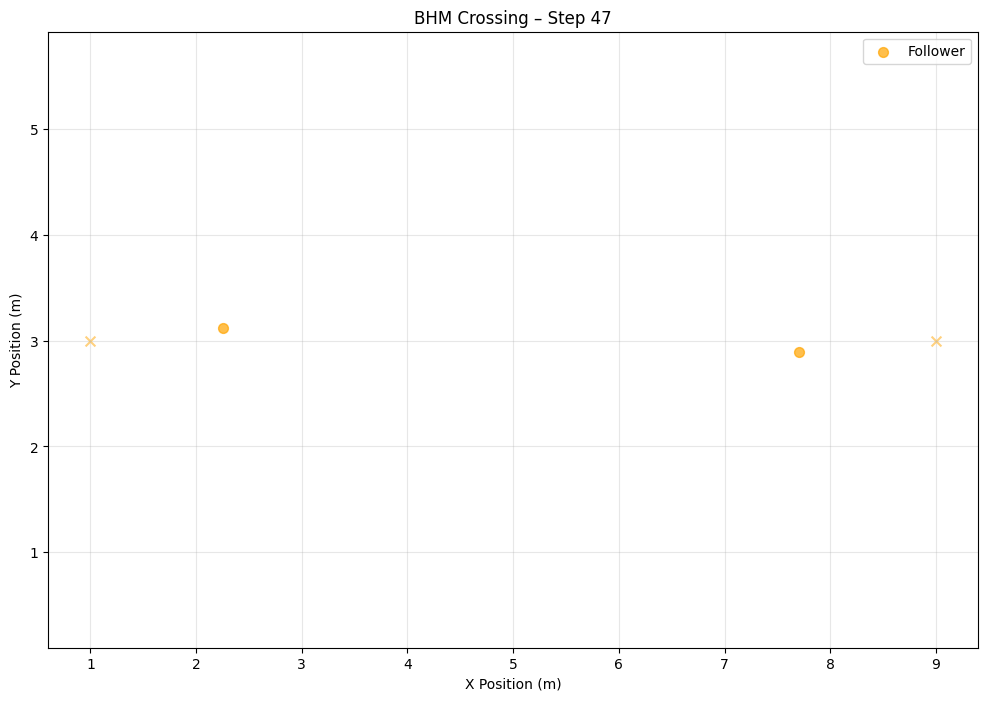

Step 48


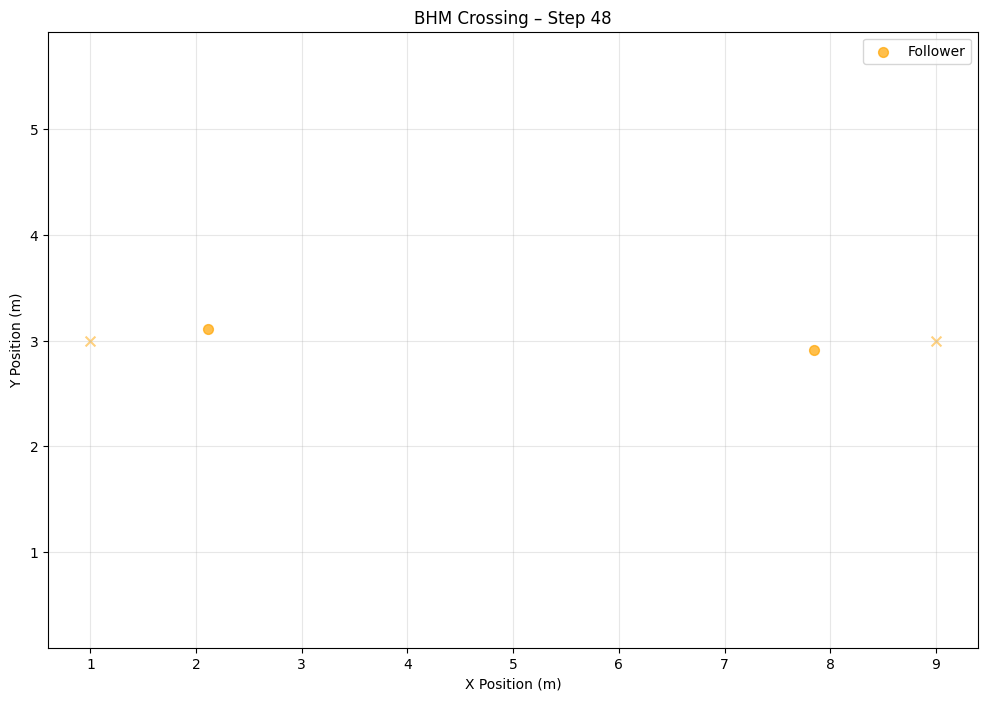

Step 49


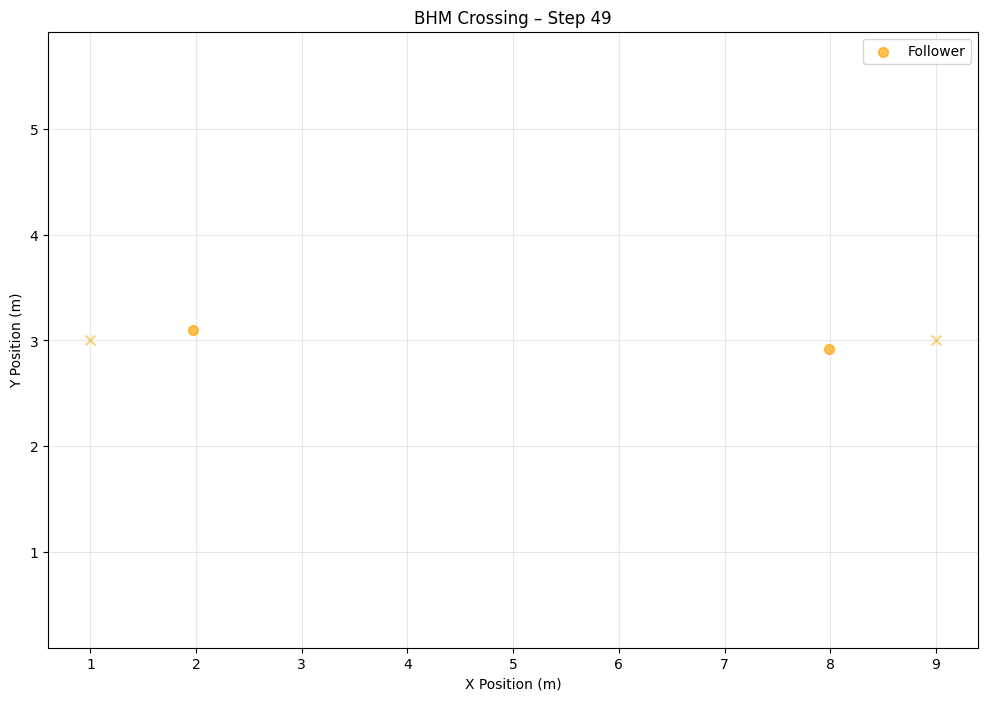

Step 50


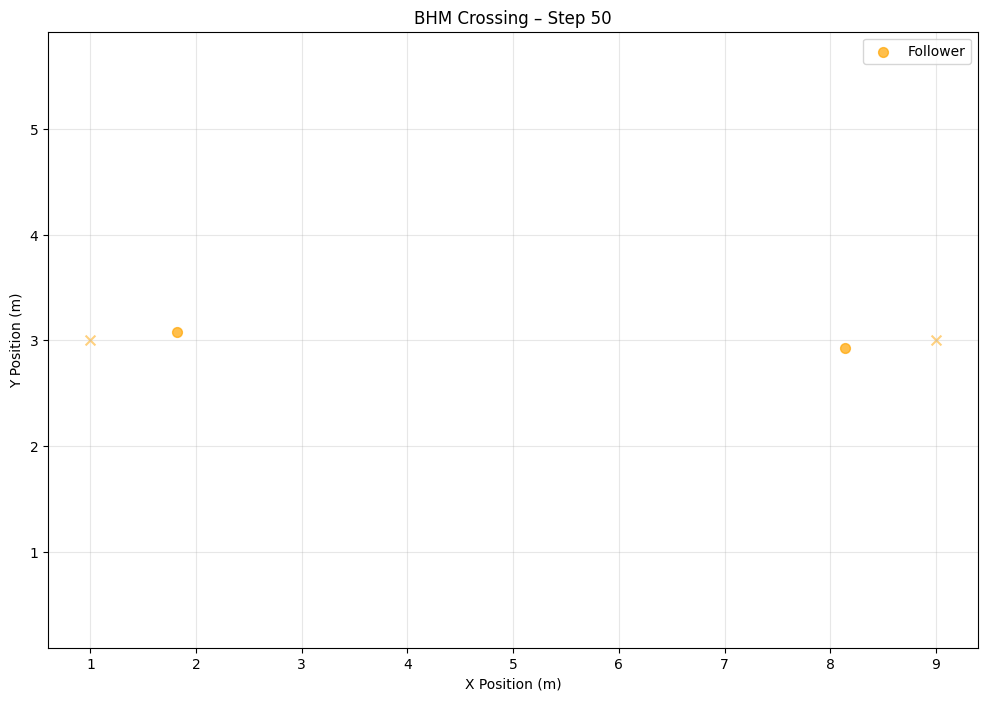

Step 51


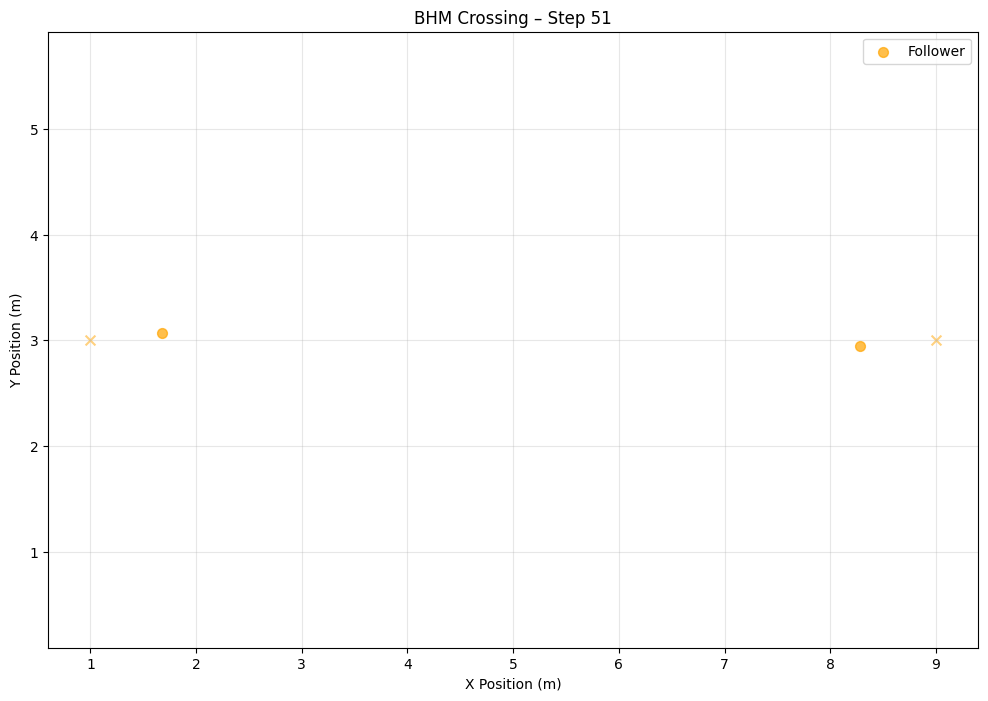

Step 52


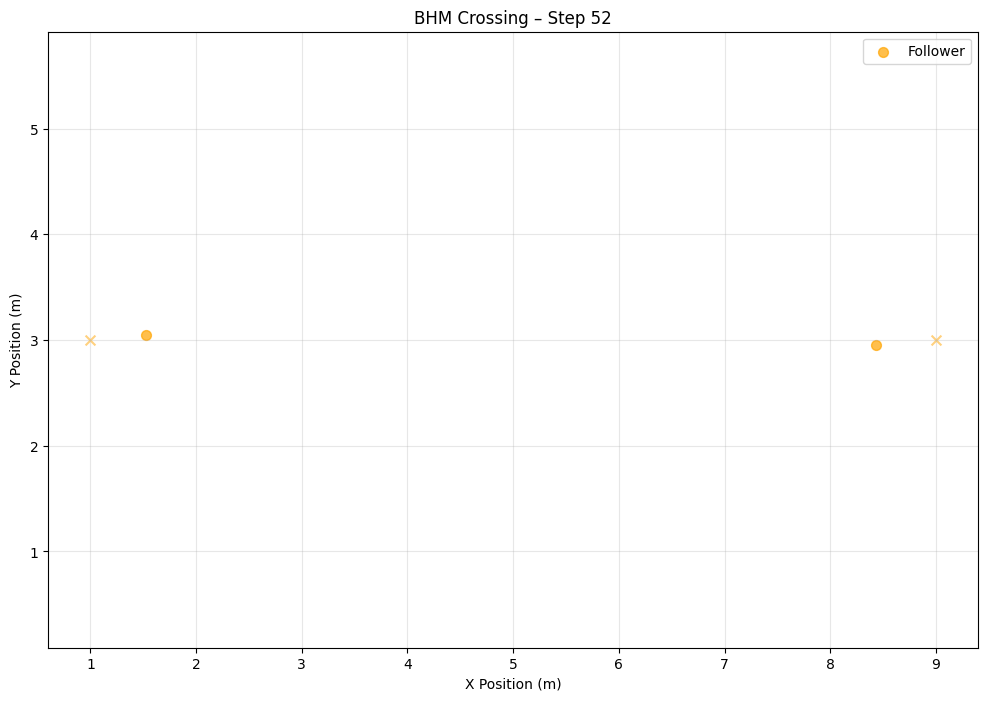

All pedestrians reached their targets at step 53!


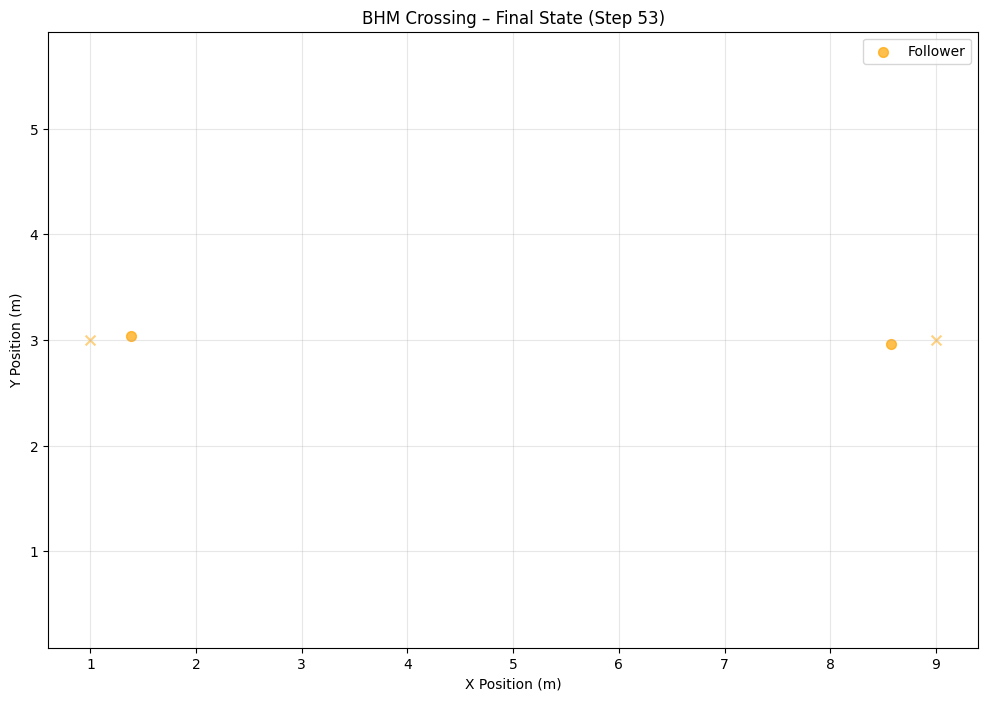

Simulation complete!


In [33]:
# (Assume BehavioralHeuristicsModel class as defined previously is already imported here)

def create_bottleneck_scenario() -> BehavioralHeuristicsModel:
    """
    Create a simple crossing scenario where two pedestrians start
    on opposite sides and walk to each other's starting position.
    """
    model = BehavioralHeuristicsModel(max_agents=2, scenario_width=10.0, scenario_height=6.0)

    # No obstacles for the crossing scenario

    # Pedestrian 1: start left → go right
    start1 = (1.0, 3.0)
    target1 = (9.0, 3.0)
    model.add_agent(start1, target1, heuristic=model.FOLLOWER)

    # Pedestrian 2: start right → go left
    start2 = (9.0, 3.0)
    target2 = (1.0, 3.0)
    model.add_agent(start2, target2, heuristic=model.FOLLOWER)

    return model

def check_all_targets_reached(model: BehavioralHeuristicsModel, tolerance: float = 0.5) -> bool:
    """
    Check if all active agents have reached their targets within tolerance distance.
    Returns True if all agents reached targets or no agents are active.
    """
    data = model.get_agent_data()

    # If no active agents, consider targets reached
    if not data['positions']:
        return True

    # Check each active agent
    for i, (pos, target) in enumerate(zip(data['positions'], data['targets'])):
        distance = ((pos[0] - target[0])**2 + (pos[1] - target[1])**2)**0.5
        if distance > tolerance:
            return False  # At least one agent hasn't reached target

    return True  # All agents reached their targets

def visualize_simulation(model: BehavioralHeuristicsModel, title: str = "BHM Simulation"):
    """Visualize the current state of the simulation (unchanged)."""
    plt.figure(figsize=(12, 8))
    data = model.get_agent_data()
    if data['positions']:
        positions = np.array(data['positions'])
        targets   = np.array(data['targets'])
        heuristics = np.array(data['heuristics'])
        colors = ['red', 'blue', 'green', 'orange']
        names  = ['Step/Wait', 'Tangential', 'Sideways', 'Follower']
        for h in range(4):
            mask = heuristics == h
            if np.any(mask):
                plt.scatter(positions[mask,0], positions[mask,1],
                            c=colors[h], label=names[h], alpha=0.7, s=50)
                plt.scatter(targets[mask,0],   targets[mask,1],
                            c=colors[h], marker='x', alpha=0.5, s=50)
    # Obstacles
    for i in range(model.num_obstacles[None]):
        pos = model.obstacles[i]
        r   = model.obstacle_radii[i]
        circle = plt.Circle((pos.x, pos.y), r, color='black', alpha=0.8)
        plt.gca().add_patch(circle)
    plt.xlim(0, model.scenario_width)
    plt.ylim(0, model.scenario_height)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.axis('equal')
    plt.show()

def run_simulation_example():
    """Run the crossing scenario example with automatic termination."""
    print("Creating crossing scenario...")
    model = create_bottleneck_scenario()

    print("Initial state:")
    visualize_simulation(model, "BHM Crossing – Initial State")

    dt = 0.1
    max_steps = 100  # Maximum steps to prevent infinite loops
    step = 0

    # Run simulation until targets reached or max steps
    while step < max_steps:
        model.update(dt)
        step += 1

        # Check if all targets are reached
        if check_all_targets_reached(model, tolerance=0.5):
            print(f"All pedestrians reached their targets at step {step}!")
            visualize_simulation(model, f"BHM Crossing – Final State (Step {step})")
            break

        # Visualize every step for detailed observation
        if step % 1 == 0:
            print(f"Step {step}")
            visualize_simulation(model, f"BHM Crossing – Step {step}")

    if step >= max_steps:
        print(f"Simulation reached maximum steps ({max_steps}) without all targets being reached.")

    print("Simulation complete!")

# Execute the example
if __name__ == "__main__":
    run_simulation_example()


In [34]:
# Complete Trajectory Recording System for BHM Simulation
# Copy and run this cell after ensuring your BehavioralHeuristicsModel is available

import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple, Dict

def record_trajectories_to_csv(model, dt=0.1, max_steps=20, filename='bhm_trajectories.csv'):
    """
    Run simulation and record complete trajectory data to CSV file
    """
    # Prepare CSV file with headers
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['time', 'agent_id', 'x', 'y', 'vx', 'vy', 'target_x', 'target_y', 'heuristic', 'active'])

    trajectory_data = []
    step = 0

    # Record initial state
    time = 0.0
    data = model.get_agent_data()
    for i, (pos, target, vel, heuristic, active) in enumerate(zip(
        data['positions'], data['targets'], data['velocities'],
        data['heuristics'], data['active'])):

        row = [time, i, pos[0], pos[1], vel[0], vel[1],
               target[0], target[1], heuristic, active]
        trajectory_data.append(row)

        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(row)

    # Run simulation and record each step
    while step < max_steps:
        model.update(dt)
        step += 1
        time = step * dt

        data = model.get_agent_data()

        for i, (pos, target, vel, heuristic, active) in enumerate(zip(
            data['positions'], data['targets'], data['velocities'],
            data['heuristics'], data['active'])):

            row = [time, i, pos[0], pos[1], vel[0], vel[1],
                   target[0], target[1], heuristic, active]
            trajectory_data.append(row)

            with open(filename, 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(row)

        # Check if all targets reached
        if not any(data['active']):
            print(f"All agents reached targets at step {step}")
            break

    print(f"Trajectory data saved to {filename}")
    print(f"Total records: {len(trajectory_data)}")
    return trajectory_data

def generate_experimental_format(model, dt=0.1, max_steps=100, filename='experimental_format.csv'):
    """
    Generate data in experimental research format
    """
    # Get initial state
    initial_data = model.get_agent_data()
    initial_positions = initial_data['positions']

    # Run simulation to completion
    step = 0
    while step < max_steps:
        model.update(dt)
        step += 1

        current_data = model.get_agent_data()
        if not any(current_data['active']):
            break

    # Get final state
    final_data = model.get_agent_data()
    final_positions = final_data['positions']

    if len(initial_positions) >= 2 and len(final_positions) >= 2:
        row = [
            initial_positions[0][0], initial_positions[0][1],  # ped1 initial
            final_positions[0][0], final_positions[0][1],     # ped1 final
            1.34,  # ped1 desired speed
            initial_positions[1][0], initial_positions[1][1],  # ped2 initial
            final_positions[1][0], final_positions[1][1],     # ped2 final
            1.34,  # ped2 desired speed
            1      # experiment number
        ]

        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(row)

        print(f"Experimental format data saved to {filename}")
        return row
    else:
        print("Error: Not enough agents for experimental format")
        return None

def analyze_trajectories(csv_file='bhm_trajectories.csv'):
    """
    Load and analyze trajectory data from CSV file
    """
    try:
        df = pd.read_csv(csv_file)

        print(f"Trajectory Analysis for {csv_file}")
        print("="*50)
        print(f"Total records: {len(df)}")
        print(f"Unique agents: {df['agent_id'].nunique()}")
        print(f"Time range: {df['time'].min():.2f} - {df['time'].max():.2f} seconds")
        print(f"Simulation duration: {df['time'].max() - df['time'].min():.2f} seconds")

        for agent_id in df['agent_id'].unique():
            agent_df = df[df['agent_id'] == agent_id]

            initial_pos = (agent_df.iloc[0]['x'], agent_df.iloc[0]['y'])
            final_pos = (agent_df.iloc[-1]['x'], agent_df.iloc[-1]['y'])
            target_pos = (agent_df.iloc[0]['target_x'], agent_df.iloc[0]['target_y'])

            # Calculate path length
            path_length = 0
            for i in range(1, len(agent_df)):
                dx = agent_df.iloc[i]['x'] - agent_df.iloc[i-1]['x']
                dy = agent_df.iloc[i]['y'] - agent_df.iloc[i-1]['y']
                path_length += np.sqrt(dx**2 + dy**2)

            final_error = np.sqrt((final_pos[0] - target_pos[0])**2 +
                                 (final_pos[1] - target_pos[1])**2)

            print(f"\nAgent {agent_id}:")
            print(f"  Initial position: ({initial_pos[0]:.2f}, {initial_pos[1]:.2f})")
            print(f"  Final position: ({final_pos[0]:.2f}, {final_pos[1]:.2f})")
            print(f"  Target position: ({target_pos[0]:.2f}, {target_pos[1]:.2f})")
            print(f"  Path length: {path_length:.2f} m")
            print(f"  Final error: {final_error:.2f} m")
            print(f"  Average speed: {path_length / df['time'].max():.2f} m/s")

        return df

    except FileNotFoundError:
        print(f"Error: {csv_file} not found. Run simulation first.")
        return None

def visualize_trajectories(csv_file='bhm_trajectories.csv'):
    """
    Create trajectory visualization from CSV data
    """
    try:
        df = pd.read_csv(csv_file)

        plt.figure(figsize=(10, 6))
        colors = ['red', 'blue', 'green', 'orange']

        for agent_id in df['agent_id'].unique():
            agent_df = df[df['agent_id'] == agent_id]

            plt.plot(agent_df['x'], agent_df['y'],
                    color=colors[agent_id % len(colors)],
                    linewidth=2, label=f'Agent {agent_id}')

            plt.scatter(agent_df.iloc[0]['x'], agent_df.iloc[0]['y'],
                       s=100, color=colors[agent_id % len(colors)],
                       marker='o', edgecolor='black', linewidth=2)

            plt.scatter(agent_df.iloc[-1]['x'], agent_df.iloc[-1]['y'],
                       s=100, color=colors[agent_id % len(colors)],
                       marker='s', edgecolor='black', linewidth=2)

            plt.scatter(agent_df.iloc[0]['target_x'], agent_df.iloc[0]['target_y'],
                       s=150, color=colors[agent_id % len(colors)],
                       marker='X', alpha=0.7)

        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.title('Pedestrian Trajectories')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error creating visualization: {e}")

# Main execution function
def run_complete_simulation():
    """
    Main function to run simulation and generate all trajectory files
    """
    print("BHM Simulation with Trajectory Recording")
    print("="*50)

    # 1. Create the crossing scenario
    model = create_bottleneck_scenario()  # Your crossing scenario function

    # 2. Record detailed trajectories
    print("Recording detailed trajectories...")
    trajectory_data = record_trajectories_to_csv(
        model,
        dt=0.1,
        max_steps=100,
        filename='bhm_detailed_trajectories.csv'
    )

    # 3. Generate experimental format data
    print("\nGenerating experimental format data...")
    model_exp = create_bottleneck_scenario()  # Fresh model
    exp_data = generate_experimental_format(
        model_exp,
        dt=0.1,
        max_steps=100,
        filename='bhm_experimental_format.csv'
    )

    # 4. Analyze results
    print("\nAnalyzing trajectory data...")
    df = analyze_trajectories('bhm_detailed_trajectories.csv')

    # 5. Create visualization
    print("\nCreating trajectory visualization...")
    visualize_trajectories('bhm_detailed_trajectories.csv')

    print("\nFiles Generated:")
    print("- bhm_detailed_trajectories.csv (complete trajectory data)")
    print("- bhm_experimental_format.csv (research paper format)")

    return trajectory_data, exp_data, df

# TO RUN THE SIMULATION:
# Uncomment the line below after ensuring your BehavioralHeuristicsModel is available


BHM Simulation with Trajectory Recording
Recording detailed trajectories...
Trajectory data saved to bhm_detailed_trajectories.csv
Total records: 202

Generating experimental format data...
Experimental format data saved to bhm_experimental_format.csv

Analyzing trajectory data...
Trajectory Analysis for bhm_detailed_trajectories.csv
Total records: 202
Unique agents: 2
Time range: 0.00 - 10.00 seconds
Simulation duration: 10.00 seconds

Agent 0:
  Initial position: (1.00, 3.00)
  Final position: (9.01, 3.00)
  Target position: (9.00, 3.00)
  Path length: 14.63 m
  Final error: 0.01 m
  Average speed: 1.46 m/s

Agent 1:
  Initial position: (9.00, 3.00)
  Final position: (0.95, 2.99)
  Target position: (1.00, 3.00)
  Path length: 14.68 m
  Final error: 0.05 m
  Average speed: 1.47 m/s

Creating trajectory visualization...


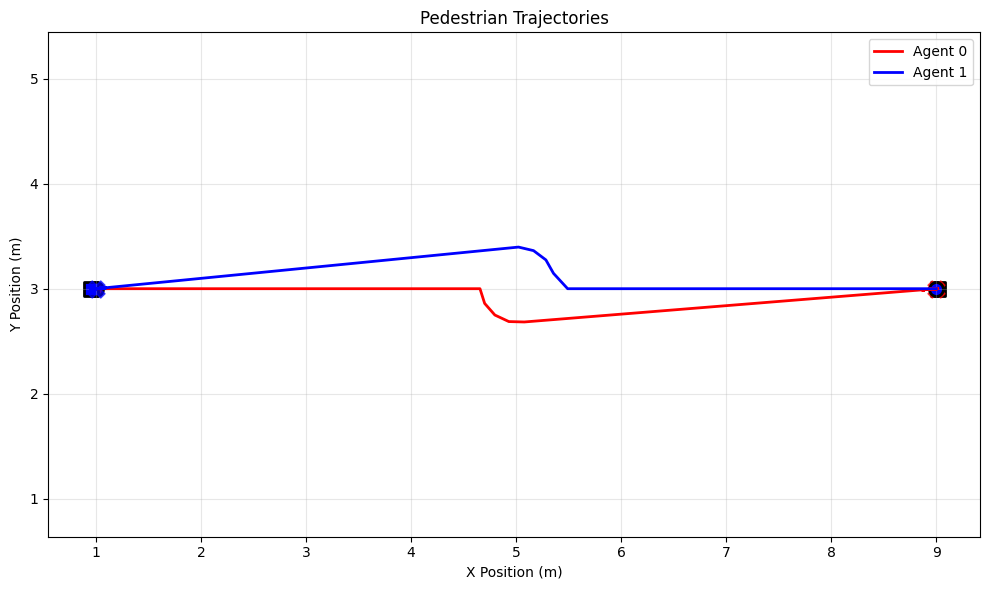


Files Generated:
- bhm_detailed_trajectories.csv (complete trajectory data)
- bhm_experimental_format.csv (research paper format)


In [35]:
trajectory_data, exp_data, df = run_complete_simulation()

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

# Enable inline animations for Jupyter/Colab
from matplotlib import rc
rc('animation', html='html5')

class TargetBasedPedestrianAnimator:
    """
    Enhanced animation class with automatic termination when targets are reached
    """

    def __init__(self, scenario_width=10.0, scenario_height=6.0, target_threshold=0.3):
        self.scenario_width = scenario_width
        self.scenario_height = scenario_height
        self.target_threshold = target_threshold  # Distance threshold for target reached
        self.colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
        self.heuristic_names = ['Step/Wait', 'Tangential', 'Sideways', 'Follower']

    def check_targets_reached(self, data):
        """
        Check if all active agents have reached their targets within threshold
        """
        if not data['positions']:
            return True

        for i, (pos, target, active) in enumerate(zip(
            data['positions'], data['targets'], data['active'])):
            if active:
                distance = np.sqrt((pos[0] - target[0])**2 + (pos[1] - target[1])**2)
                if distance > self.target_threshold:
                    return False
        return True

    def run_simulation_until_targets_reached(self, model, dt=0.1, max_steps=200):
        """
        Run simulation and record trajectory data until all targets are reached
        """
        trajectory_data = []
        step = 0

        print("🎯 Starting target-based simulation...")

        # Record initial state
        data = model.get_agent_data()
        for i, (pos, target, vel, heuristic, active) in enumerate(zip(
            data['positions'], data['targets'], data['velocities'],
            data['heuristics'], data['active'])):

            distance_to_target = np.sqrt((pos[0] - target[0])**2 + (pos[1] - target[1])**2)

            trajectory_data.append({
                'time': 0.0,
                'step': 0,
                'agent_id': i,
                'x': pos[0], 'y': pos[1],
                'vx': vel[0], 'vy': vel[1],
                'target_x': target[0], 'target_y': target[1],
                'distance_to_target': distance_to_target,
                'heuristic': heuristic,
                'active': active
            })

        # Run simulation until targets reached or max steps
        while step < max_steps:
            model.update(dt)
            step += 1
            time = step * dt

            data = model.get_agent_data()

            # Record current step data
            for i, (pos, target, vel, heuristic, active) in enumerate(zip(
                data['positions'], data['targets'], data['velocities'],
                data['heuristics'], data['active'])):

                distance_to_target = np.sqrt((pos[0] - target[0])**2 + (pos[1] - target[1])**2)

                trajectory_data.append({
                    'time': time,
                    'step': step,
                    'agent_id': i,
                    'x': pos[0], 'y': pos[1],
                    'vx': vel[0], 'vy': vel[1],
                    'target_x': target[0], 'target_y': target[1],
                    'distance_to_target': distance_to_target,
                    'heuristic': heuristic,
                    'active': active
                })

            # Check if all targets reached
            if self.check_targets_reached(data):
                print(f"🎉 All pedestrians reached targets at step {step} (time: {time:.1f}s)")
                break

            # Progress update every 10 steps
            if step % 10 == 0:
                active_count = sum(data['active'])
                min_dist = min([np.sqrt((pos[0] - target[0])**2 + (pos[1] - target[1])**2)
                               for pos, target, active in zip(data['positions'], data['targets'], data['active'])
                               if active] or [0])
                print(f"Step {step}: Active agents: {active_count}, Min distance to target: {min_dist:.3f}m")

        if step >= max_steps:
            print(f"⚠️ Simulation reached max steps ({max_steps}) without all targets being reached")

        self.df = pd.DataFrame(trajectory_data)
        self.final_step = step
        self.final_time = time if step < max_steps else max_steps * dt

        print(f"📊 Simulation completed: {step} steps, {self.final_time:.1f} seconds")
        return self.df

    def create_target_focused_animation(self, show_trails=True, show_targets=True,
                                      show_threshold_circles=True, interval=150,
                                      save_mp4=False, filename='target_focused_animation.mp4'):
        """
        Create animation with target focus and automatic termination visualization
        """
        if not hasattr(self, 'df'):
            raise ValueError("No trajectory data available. Run simulation first.")

        # Set up the figure and axis
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_xlim(-0.5, self.scenario_width + 0.5)
        ax.set_ylim(-0.5, self.scenario_height + 0.5)
        ax.set_xlabel('X Position (m)', fontsize=12)
        ax.set_ylabel('Y Position (m)', fontsize=12)
        ax.set_title('Target-Based Pedestrian Simulation - BHM Model', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')

        # Get unique time steps and agents
        time_steps = sorted(self.df['time'].unique())
        agent_ids = sorted(self.df['agent_id'].unique())

        # Initialize plot elements
        agent_dots = {}
        trail_lines = {}
        target_markers = {}
        threshold_circles = {}

        for agent_id in agent_ids:
            color = self.colors[agent_id % len(self.colors)]

            # Current position markers (larger for better visibility)
            agent_dots[agent_id] = ax.scatter([], [], s=200, c=color,
                                            edgecolors='black', linewidth=2,
                                            alpha=0.9, zorder=5, label=f'Pedestrian {agent_id}')

            # Trail lines
            if show_trails:
                trail_lines[agent_id], = ax.plot([], [], '-', color=color,
                                                alpha=0.6, linewidth=2, zorder=3)

            # Target markers and threshold circles
            if show_targets:
                agent_data = self.df[self.df['agent_id'] == agent_id].iloc[0]
                target_x, target_y = agent_data['target_x'], agent_data['target_y']

                # Target marker (star shape)
                target_markers[agent_id] = ax.scatter(target_x, target_y,
                                                    s=300, c=color, marker='*',
                                                    alpha=0.8, edgecolors='black',
                                                    linewidth=2, zorder=4)

                # Threshold circle
                if show_threshold_circles:
                    threshold_circles[agent_id] = plt.Circle((target_x, target_y),
                                                           self.target_threshold,
                                                           fill=False, color=color,
                                                           linestyle='--', alpha=0.5)
                    ax.add_patch(threshold_circles[agent_id])

        # Animation info text
        info_text = ax.text(0.02, 0.98, '', transform=ax.transAxes,
                           fontsize=11, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        # Status text
        status_text = ax.text(0.02, 0.90, '', transform=ax.transAxes,
                             fontsize=10, verticalalignment='top',
                             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        # Legend
        ax.legend(loc='upper right', fontsize=10)

        def animate(frame_num):
            """Enhanced animation update function with target tracking"""
            if frame_num >= len(time_steps):
                return []

            current_time = time_steps[frame_num]
            current_data = self.df[self.df['time'] == current_time]

            updated_elements = []
            active_agents = 0
            targets_reached = 0
            min_distance = float('inf')

            for agent_id in agent_ids:
                agent_frame_data = current_data[current_data['agent_id'] == agent_id]

                if not agent_frame_data.empty:
                    row = agent_frame_data.iloc[0]
                    x, y = row['x'], row['y']
                    distance_to_target = row['distance_to_target']

                    if row['active']:
                        active_agents += 1

                        # Update current position
                        agent_dots[agent_id].set_offsets([[x, y]])

                        # Check if reached target
                        if distance_to_target <= self.target_threshold:
                            targets_reached += 1
                            # Change appearance when target reached
                            agent_dots[agent_id].set_sizes([300])  # Larger size
                            agent_dots[agent_id].set_alpha(0.7)
                        else:
                            agent_dots[agent_id].set_sizes([200])
                            agent_dots[agent_id].set_alpha(0.9)

                        min_distance = min(min_distance, distance_to_target)

                        # Update trail
                        if show_trails and agent_id in trail_lines:
                            agent_history = self.df[(self.df['agent_id'] == agent_id) &
                                                  (self.df['time'] <= current_time)]
                            if len(agent_history) > 1:
                                trail_lines[agent_id].set_data(agent_history['x'], agent_history['y'])
                    else:
                        # Hide inactive agents
                        agent_dots[agent_id].set_offsets(np.empty((0, 2)))

                    updated_elements.append(agent_dots[agent_id])
                    if show_trails and agent_id in trail_lines:
                        updated_elements.append(trail_lines[agent_id])

            # Update info text
            info_text.set_text(f'Time: {current_time:.1f}s | Step: {frame_num} | Active: {active_agents}')

            # Update status text
            if min_distance != float('inf'):
                status_text.set_text(f'Targets reached: {targets_reached}/{len(agent_ids)} | '
                                   f'Min distance: {min_distance:.3f}m')
            else:
                status_text.set_text('Simulation complete')

            updated_elements.extend([info_text, status_text])

            return updated_elements

        # Create animation
        anim = animation.FuncAnimation(fig, animate, frames=len(time_steps),
                                     interval=interval, blit=True, repeat=True)

        # Save as MP4 if requested
        if save_mp4:
            print(f"💾 Saving animation as {filename}...")
            writer = animation.FFMpegWriter(fps=1000//interval, bitrate=1800)
            anim.save(filename, writer=writer)
            print("✅ Animation saved successfully!")

        plt.close()  # Prevent duplicate static display
        return anim

    def export_target_focused_trajectories(self, filename='target_focused_trajectories.csv'):
        """
        Export trajectory data with target information
        """
        if hasattr(self, 'df'):
            self.df.to_csv(filename, index=False)
            print(f"📁 Trajectory data exported to: {filename}")

            # Print summary statistics
            print("\n📈 Simulation Summary:")
            print(f"Duration: {self.final_time:.1f} seconds ({self.final_step} steps)")
            print(f"Target threshold: {self.target_threshold:.2f}m")

            for agent_id in self.df['agent_id'].unique():
                agent_df = self.df[self.df['agent_id'] == agent_id]
                final_distance = agent_df.iloc[-1]['distance_to_target']
                path_length = 0

                # Calculate path length
                for i in range(1, len(agent_df)):
                    dx = agent_df.iloc[i]['x'] - agent_df.iloc[i-1]['x']
                    dy = agent_df.iloc[i]['y'] - agent_df.iloc[i-1]['y']
                    path_length += np.sqrt(dx**2 + dy**2)

                print(f"Agent {agent_id}: Final distance to target: {final_distance:.3f}m, "
                      f"Path length: {path_length:.2f}m")

            return self.df
        else:
            print("❌ No trajectory data to export. Run simulation first.")
            return None

# Main execution function
def run_target_based_bhm_animation():
    """
    Complete function to run target-based BHM simulation with automatic termination
    """
    print("🎯 Target-Based BHM Pedestrian Simulation")
    print("="*60)

    # 1. Create simulation model
    print("1. Setting up crossing scenario...")
    model = create_bottleneck_scenario()  # Your existing function

    # 2. Create target-based animator
    animator = TargetBasedPedestrianAnimator(
        scenario_width=10.0,
        scenario_height=6.0,
        target_threshold=0.3  # Stop when within 30cm of target
    )

    # 3. Run simulation until targets reached
    print("2. Running simulation until targets are reached...")
    df = animator.run_simulation_until_targets_reached(model, dt=0.1, max_steps=200)

    # 4. Create target-focused animation
    print("3. Creating target-focused animation...")
    main_anim = animator.create_target_focused_animation(
        show_trails=True,
        show_targets=True,
        show_threshold_circles=True,
        interval=200,  # Slower animation (5fps) for better observation
        save_mp4=False  # Set to True to save as video
    )

    # 5. Export trajectory data
    print("4. Exporting trajectory data...")
    trajectory_df = animator.export_target_focused_trajectories()

    print("\n✅ Target-based simulation completed successfully!")
    print("\n🎬 Displaying animation...")

    # Display animation
    display(HTML(main_anim.to_jshtml()))

    return animator, main_anim, trajectory_df

# TO RUN THE TARGET-BASED ANIMATION:
# Uncomment the line below to execute


In [37]:
animator, main_anim, trajectory_df = run_target_based_bhm_animation()

🎯 Target-Based BHM Pedestrian Simulation
1. Setting up crossing scenario...
2. Running simulation until targets are reached...
🎯 Starting target-based simulation...
Step 10: Active agents: 2, Min distance to target: 6.538m
Step 20: Active agents: 2, Min distance to target: 5.075m
Step 30: Active agents: 2, Min distance to target: 3.750m
Step 40: Active agents: 2, Min distance to target: 2.287m
Step 50: Active agents: 2, Min distance to target: 0.825m
🎉 All pedestrians reached targets at step 54 (time: 5.4s)
📊 Simulation completed: 54 steps, 5.4 seconds
3. Creating target-focused animation...
4. Exporting trajectory data...
📁 Trajectory data exported to: target_focused_trajectories.csv

📈 Simulation Summary:
Duration: 5.4 seconds (54 steps)
Target threshold: 0.30m
Agent 0: Final distance to target: 0.279m, Path length: 7.90m
Agent 1: Final distance to target: 0.240m, Path length: 7.95m

✅ Target-based simulation completed successfully!

🎬 Displaying animation...
